# Getting Started w/ GANs
https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5 <br>
https://jovian.ml/shubham7169007/cat-dcgan

In [78]:
# imports
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
DATA_DIR = '/Users/hassankhawaja/Desktop/GAN/space'

In [101]:
# https://www.geeksforgeeks.org/python-os-listdir-method/
print(os.listdir(DATA_DIR)[:10])

['space-images', '.DS_Store']


In [102]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [103]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [104]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [105]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [106]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=6).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

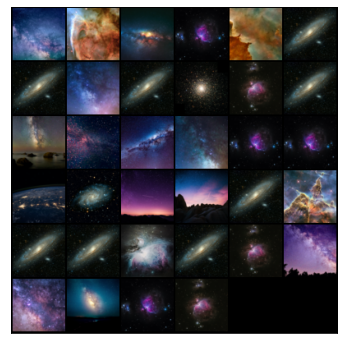

In [107]:
show_batch(train_dl)

In [108]:
# !pip install jovian --upgrade --quiet

In [109]:
# import jovian

In [110]:
# jovian.commit(project='project_name', environment=None)

In [111]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [112]:
device = get_default_device()
device

device(type='cpu')

In [113]:
train_dl = DeviceDataLoader(train_dl, device)

In [114]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [115]:
discriminator = to_device(discriminator, device)

In [116]:
latent_size = 128

In [117]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [118]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
# show_images(fake_images) # this shows image of the grid

torch.Size([128, 3, 64, 64])


In [119]:
generator = to_device(generator, device)

In [120]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [121]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [122]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [123]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [124]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [125]:
# save_samples(0, fixed_latent)
# this outputs an image of 8x8 grid

In [126]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [127]:
lr = 0.0002
# epochs = 60
# This takes hours to run
epochs = 1500

In [128]:
history = fit(epochs, lr)


Epoch [1/1500], loss_g: 2.6318, loss_d: 1.4087, real_score: 0.6280, fake_score: 0.6003
Saving generated-images-0001.png



Epoch [2/1500], loss_g: 3.3820, loss_d: 0.7650, real_score: 0.9345, fake_score: 0.4922
Saving generated-images-0002.png



Epoch [3/1500], loss_g: 4.2416, loss_d: 0.3993, real_score: 0.9229, fake_score: 0.2652
Saving generated-images-0003.png



Epoch [4/1500], loss_g: 4.7663, loss_d: 0.2609, real_score: 0.9229, fake_score: 0.1604
Saving generated-images-0004.png



Epoch [5/1500], loss_g: 5.1721, loss_d: 0.2019, real_score: 0.9331, fake_score: 0.1217
Saving generated-images-0005.png



Epoch [6/1500], loss_g: 5.4271, loss_d: 0.1408, real_score: 0.9513, fake_score: 0.0858
Saving generated-images-0006.png



Epoch [7/1500], loss_g: 6.0226, loss_d: 0.1234, real_score: 0.9674, fake_score: 0.0852
Saving generated-images-0007.png



Epoch [8/1500], loss_g: 6.1581, loss_d: 0.0854, real_score: 0.9708, fake_score: 0.0537
Saving generated-images-0008.png



Epoch [9/1500], loss_g: 6.2024, loss_d: 0.0750, real_score: 0.9769, fake_score: 0.0499
Saving generated-images-0009.png



Epoch [10/1500], loss_g: 6.7401, loss_d: 0.0763, real_score: 0.9805, fake_score: 0.0546
Saving generated-images-0010.png



Epoch [11/1500], loss_g: 6.9770, loss_d: 0.0600, real_score: 0.9807, fake_score: 0.0394
Saving generated-images-0011.png



Epoch [12/1500], loss_g: 7.0119, loss_d: 0.0549, real_score: 0.9829, fake_score: 0.0368
Saving generated-images-0012.png



Epoch [13/1500], loss_g: 7.1267, loss_d: 0.0486, real_score: 0.9853, fake_score: 0.0330
Saving generated-images-0013.png



Epoch [14/1500], loss_g: 7.4995, loss_d: 0.0479, real_score: 0.9872, fake_score: 0.0343
Saving generated-images-0014.png



Epoch [15/1500], loss_g: 7.4819, loss_d: 0.0384, real_score: 0.9880, fake_score: 0.0259
Saving generated-images-0015.png



Epoch [16/1500], loss_g: 7.6027, loss_d: 0.0356, real_score: 0.9892, fake_score: 0.0244
Saving generated-images-0016.png



Epoch [17/1500], loss_g: 7.4210, loss_d: 0.0267, real_score: 0.9901, fake_score: 0.0166
Saving generated-images-0017.png



Epoch [18/1500], loss_g: 7.5807, loss_d: 0.0286, real_score: 0.9917, fake_score: 0.0199
Saving generated-images-0018.png



Epoch [19/1500], loss_g: 7.8406, loss_d: 0.0264, real_score: 0.9925, fake_score: 0.0186
Saving generated-images-0019.png



Epoch [20/1500], loss_g: 7.8059, loss_d: 0.0218, real_score: 0.9928, fake_score: 0.0145
Saving generated-images-0020.png



Epoch [21/1500], loss_g: 7.7322, loss_d: 0.0216, real_score: 0.9933, fake_score: 0.0148
Saving generated-images-0021.png



Epoch [22/1500], loss_g: 7.8368, loss_d: 0.0203, real_score: 0.9937, fake_score: 0.0138
Saving generated-images-0022.png



Epoch [23/1500], loss_g: 7.9177, loss_d: 0.0206, real_score: 0.9940, fake_score: 0.0145
Saving generated-images-0023.png



Epoch [24/1500], loss_g: 8.1975, loss_d: 0.0220, real_score: 0.9941, fake_score: 0.0160
Saving generated-images-0024.png



Epoch [25/1500], loss_g: 7.8599, loss_d: 0.0158, real_score: 0.9938, fake_score: 0.0095
Saving generated-images-0025.png



Epoch [26/1500], loss_g: 7.9076, loss_d: 0.0193, real_score: 0.9943, fake_score: 0.0135
Saving generated-images-0026.png



Epoch [27/1500], loss_g: 8.1650, loss_d: 0.0182, real_score: 0.9944, fake_score: 0.0125
Saving generated-images-0027.png



Epoch [28/1500], loss_g: 8.0393, loss_d: 0.0147, real_score: 0.9944, fake_score: 0.0090
Saving generated-images-0028.png



Epoch [29/1500], loss_g: 8.5091, loss_d: 0.0203, real_score: 0.9948, fake_score: 0.0149
Saving generated-images-0029.png



Epoch [30/1500], loss_g: 8.0583, loss_d: 0.0121, real_score: 0.9943, fake_score: 0.0063
Saving generated-images-0030.png



Epoch [31/1500], loss_g: 8.4054, loss_d: 0.0183, real_score: 0.9949, fake_score: 0.0131
Saving generated-images-0031.png



Epoch [32/1500], loss_g: 8.1385, loss_d: 0.0115, real_score: 0.9948, fake_score: 0.0063
Saving generated-images-0032.png



Epoch [33/1500], loss_g: 7.9141, loss_d: 0.0122, real_score: 0.9955, fake_score: 0.0076
Saving generated-images-0033.png



Epoch [34/1500], loss_g: 8.1851, loss_d: 0.0137, real_score: 0.9961, fake_score: 0.0097
Saving generated-images-0034.png



Epoch [35/1500], loss_g: 7.9473, loss_d: 0.0097, real_score: 0.9962, fake_score: 0.0059
Saving generated-images-0035.png



Epoch [36/1500], loss_g: 8.0780, loss_d: 0.0118, real_score: 0.9965, fake_score: 0.0083
Saving generated-images-0036.png



Epoch [37/1500], loss_g: 8.1830, loss_d: 0.0118, real_score: 0.9966, fake_score: 0.0084
Saving generated-images-0037.png



Epoch [38/1500], loss_g: 7.8287, loss_d: 0.0083, real_score: 0.9966, fake_score: 0.0049
Saving generated-images-0038.png



Epoch [39/1500], loss_g: 7.6869, loss_d: 0.0096, real_score: 0.9969, fake_score: 0.0064
Saving generated-images-0039.png



Epoch [40/1500], loss_g: 8.0759, loss_d: 0.0112, real_score: 0.9971, fake_score: 0.0083
Saving generated-images-0040.png



Epoch [41/1500], loss_g: 8.3007, loss_d: 0.0100, real_score: 0.9971, fake_score: 0.0071
Saving generated-images-0041.png



Epoch [42/1500], loss_g: 8.1537, loss_d: 0.0091, real_score: 0.9971, fake_score: 0.0062
Saving generated-images-0042.png



Epoch [43/1500], loss_g: 8.0947, loss_d: 0.0084, real_score: 0.9972, fake_score: 0.0055
Saving generated-images-0043.png



Epoch [44/1500], loss_g: 7.8580, loss_d: 0.0085, real_score: 0.9973, fake_score: 0.0058
Saving generated-images-0044.png



Epoch [45/1500], loss_g: 8.1882, loss_d: 0.0109, real_score: 0.9974, fake_score: 0.0083
Saving generated-images-0045.png



Epoch [46/1500], loss_g: 8.1586, loss_d: 0.0088, real_score: 0.9973, fake_score: 0.0061
Saving generated-images-0046.png



Epoch [47/1500], loss_g: 8.0832, loss_d: 0.0090, real_score: 0.9973, fake_score: 0.0063
Saving generated-images-0047.png



Epoch [48/1500], loss_g: 8.0652, loss_d: 0.0093, real_score: 0.9973, fake_score: 0.0066
Saving generated-images-0048.png



Epoch [49/1500], loss_g: 8.0362, loss_d: 0.0082, real_score: 0.9973, fake_score: 0.0054
Saving generated-images-0049.png



Epoch [50/1500], loss_g: 7.9503, loss_d: 0.0081, real_score: 0.9974, fake_score: 0.0055
Saving generated-images-0050.png



Epoch [51/1500], loss_g: 7.9249, loss_d: 0.0073, real_score: 0.9975, fake_score: 0.0048
Saving generated-images-0051.png



Epoch [52/1500], loss_g: 7.9229, loss_d: 0.0074, real_score: 0.9977, fake_score: 0.0051
Saving generated-images-0052.png



Epoch [53/1500], loss_g: 7.8984, loss_d: 0.0079, real_score: 0.9978, fake_score: 0.0056
Saving generated-images-0053.png



Epoch [54/1500], loss_g: 8.2300, loss_d: 0.0083, real_score: 0.9977, fake_score: 0.0061
Saving generated-images-0054.png



Epoch [55/1500], loss_g: 8.0745, loss_d: 0.0061, real_score: 0.9976, fake_score: 0.0037
Saving generated-images-0055.png



Epoch [56/1500], loss_g: 7.8918, loss_d: 0.0060, real_score: 0.9977, fake_score: 0.0038
Saving generated-images-0056.png



Epoch [57/1500], loss_g: 7.9917, loss_d: 0.0073, real_score: 0.9980, fake_score: 0.0052
Saving generated-images-0057.png



Epoch [58/1500], loss_g: 8.2860, loss_d: 0.0071, real_score: 0.9980, fake_score: 0.0051
Saving generated-images-0058.png



Epoch [59/1500], loss_g: 8.3396, loss_d: 0.0074, real_score: 0.9979, fake_score: 0.0052
Saving generated-images-0059.png



Epoch [60/1500], loss_g: 8.1932, loss_d: 0.0064, real_score: 0.9977, fake_score: 0.0041
Saving generated-images-0060.png



Epoch [61/1500], loss_g: 8.3609, loss_d: 0.0074, real_score: 0.9978, fake_score: 0.0052
Saving generated-images-0061.png



Epoch [62/1500], loss_g: 8.3876, loss_d: 0.0064, real_score: 0.9978, fake_score: 0.0043
Saving generated-images-0062.png



Epoch [63/1500], loss_g: 8.1727, loss_d: 0.0057, real_score: 0.9979, fake_score: 0.0036
Saving generated-images-0063.png



Epoch [64/1500], loss_g: 8.2162, loss_d: 0.0058, real_score: 0.9981, fake_score: 0.0039
Saving generated-images-0064.png



Epoch [65/1500], loss_g: 8.1693, loss_d: 0.0051, real_score: 0.9982, fake_score: 0.0034
Saving generated-images-0065.png



Epoch [66/1500], loss_g: 8.5335, loss_d: 0.0066, real_score: 0.9983, fake_score: 0.0049
Saving generated-images-0066.png



Epoch [67/1500], loss_g: 8.3624, loss_d: 0.0040, real_score: 0.9982, fake_score: 0.0022
Saving generated-images-0067.png



Epoch [68/1500], loss_g: 8.0399, loss_d: 0.0041, real_score: 0.9984, fake_score: 0.0025
Saving generated-images-0068.png



Epoch [69/1500], loss_g: 7.9692, loss_d: 0.0045, real_score: 0.9986, fake_score: 0.0031
Saving generated-images-0069.png



Epoch [70/1500], loss_g: 8.7122, loss_d: 0.0067, real_score: 0.9986, fake_score: 0.0053
Saving generated-images-0070.png



Epoch [71/1500], loss_g: 8.5895, loss_d: 0.0035, real_score: 0.9984, fake_score: 0.0019
Saving generated-images-0071.png



Epoch [72/1500], loss_g: 8.1270, loss_d: 0.0035, real_score: 0.9985, fake_score: 0.0020
Saving generated-images-0072.png



Epoch [73/1500], loss_g: 8.1268, loss_d: 0.0044, real_score: 0.9987, fake_score: 0.0031
Saving generated-images-0073.png



Epoch [74/1500], loss_g: 8.1842, loss_d: 0.0040, real_score: 0.9987, fake_score: 0.0027
Saving generated-images-0074.png



Epoch [75/1500], loss_g: 8.3460, loss_d: 0.0047, real_score: 0.9987, fake_score: 0.0034
Saving generated-images-0075.png



Epoch [76/1500], loss_g: 8.3049, loss_d: 0.0038, real_score: 0.9986, fake_score: 0.0024
Saving generated-images-0076.png



Epoch [77/1500], loss_g: 8.1740, loss_d: 0.0042, real_score: 0.9987, fake_score: 0.0029
Saving generated-images-0077.png



Epoch [78/1500], loss_g: 8.2561, loss_d: 0.0044, real_score: 0.9987, fake_score: 0.0030
Saving generated-images-0078.png



Epoch [79/1500], loss_g: 8.2734, loss_d: 0.0043, real_score: 0.9986, fake_score: 0.0029
Saving generated-images-0079.png



Epoch [80/1500], loss_g: 8.3009, loss_d: 0.0042, real_score: 0.9986, fake_score: 0.0028
Saving generated-images-0080.png



Epoch [81/1500], loss_g: 8.1757, loss_d: 0.0036, real_score: 0.9986, fake_score: 0.0022
Saving generated-images-0081.png



Epoch [82/1500], loss_g: 8.0998, loss_d: 0.0037, real_score: 0.9987, fake_score: 0.0024
Saving generated-images-0082.png



Epoch [83/1500], loss_g: 8.0109, loss_d: 0.0034, real_score: 0.9988, fake_score: 0.0021
Saving generated-images-0083.png



Epoch [84/1500], loss_g: 8.1311, loss_d: 0.0044, real_score: 0.9988, fake_score: 0.0032
Saving generated-images-0084.png



Epoch [85/1500], loss_g: 8.2734, loss_d: 0.0042, real_score: 0.9988, fake_score: 0.0030
Saving generated-images-0085.png



Epoch [86/1500], loss_g: 8.2352, loss_d: 0.0034, real_score: 0.9987, fake_score: 0.0021
Saving generated-images-0086.png



Epoch [87/1500], loss_g: 8.1118, loss_d: 0.0036, real_score: 0.9987, fake_score: 0.0023
Saving generated-images-0087.png



Epoch [88/1500], loss_g: 8.2590, loss_d: 0.0044, real_score: 0.9988, fake_score: 0.0032
Saving generated-images-0088.png



Epoch [89/1500], loss_g: 8.4954, loss_d: 0.0044, real_score: 0.9987, fake_score: 0.0031
Saving generated-images-0089.png



Epoch [90/1500], loss_g: 8.4252, loss_d: 0.0038, real_score: 0.9986, fake_score: 0.0024
Saving generated-images-0090.png



Epoch [91/1500], loss_g: 8.3157, loss_d: 0.0039, real_score: 0.9986, fake_score: 0.0025
Saving generated-images-0091.png



Epoch [92/1500], loss_g: 8.3383, loss_d: 0.0040, real_score: 0.9987, fake_score: 0.0027
Saving generated-images-0092.png



Epoch [93/1500], loss_g: 8.4326, loss_d: 0.0037, real_score: 0.9987, fake_score: 0.0024
Saving generated-images-0093.png



Epoch [94/1500], loss_g: 8.3951, loss_d: 0.0036, real_score: 0.9987, fake_score: 0.0024
Saving generated-images-0094.png



Epoch [95/1500], loss_g: 8.5651, loss_d: 0.0043, real_score: 0.9988, fake_score: 0.0030
Saving generated-images-0095.png



Epoch [96/1500], loss_g: 8.4468, loss_d: 0.0032, real_score: 0.9987, fake_score: 0.0019
Saving generated-images-0096.png



Epoch [97/1500], loss_g: 8.3332, loss_d: 0.0026, real_score: 0.9988, fake_score: 0.0014
Saving generated-images-0097.png



Epoch [98/1500], loss_g: 8.1356, loss_d: 0.0026, real_score: 0.9989, fake_score: 0.0016
Saving generated-images-0098.png



Epoch [99/1500], loss_g: 8.5525, loss_d: 0.0046, real_score: 0.9991, fake_score: 0.0037
Saving generated-images-0099.png



Epoch [100/1500], loss_g: 9.0353, loss_d: 0.0048, real_score: 0.9989, fake_score: 0.0036
Saving generated-images-0100.png



Epoch [101/1500], loss_g: 8.8508, loss_d: 0.0026, real_score: 0.9984, fake_score: 0.0010
Saving generated-images-0101.png



Epoch [102/1500], loss_g: 8.3042, loss_d: 0.0023, real_score: 0.9987, fake_score: 0.0010
Saving generated-images-0102.png



Epoch [103/1500], loss_g: 8.0636, loss_d: 0.0029, real_score: 0.9990, fake_score: 0.0019
Saving generated-images-0103.png



Epoch [104/1500], loss_g: 8.6513, loss_d: 0.0043, real_score: 0.9991, fake_score: 0.0034
Saving generated-images-0104.png



Epoch [105/1500], loss_g: 8.8304, loss_d: 0.0036, real_score: 0.9988, fake_score: 0.0024
Saving generated-images-0105.png



Epoch [106/1500], loss_g: 8.6520, loss_d: 0.0034, real_score: 0.9986, fake_score: 0.0020
Saving generated-images-0106.png



Epoch [107/1500], loss_g: 8.6513, loss_d: 0.0032, real_score: 0.9985, fake_score: 0.0018
Saving generated-images-0107.png



Epoch [108/1500], loss_g: 8.4917, loss_d: 0.0028, real_score: 0.9986, fake_score: 0.0015
Saving generated-images-0108.png



Epoch [109/1500], loss_g: 9.3222, loss_d: 0.0049, real_score: 0.9988, fake_score: 0.0037
Saving generated-images-0109.png



Epoch [110/1500], loss_g: 8.8371, loss_d: 0.0031, real_score: 0.9982, fake_score: 0.0012
Saving generated-images-0110.png



Epoch [111/1500], loss_g: 8.6898, loss_d: 0.0038, real_score: 0.9985, fake_score: 0.0023
Saving generated-images-0111.png



Epoch [112/1500], loss_g: 10.7117, loss_d: 0.0066, real_score: 0.9985, fake_score: 0.0051
Saving generated-images-0112.png



Epoch [113/1500], loss_g: 8.5639, loss_d: 0.0053, real_score: 0.9955, fake_score: 0.0008
Saving generated-images-0113.png



Epoch [114/1500], loss_g: 7.6203, loss_d: 0.0193, real_score: 0.9857, fake_score: 0.0029
Saving generated-images-0114.png



Epoch [115/1500], loss_g: 0.0000, loss_d: 7.1563, real_score: 0.3263, fake_score: 0.0255
Saving generated-images-0115.png



Epoch [116/1500], loss_g: 13.1245, loss_d: 14.4136, real_score: 0.9957, fake_score: 1.0000
Saving generated-images-0116.png



Epoch [117/1500], loss_g: 10.1284, loss_d: 1.8021, real_score: 0.4757, fake_score: 0.0000
Saving generated-images-0117.png



Epoch [118/1500], loss_g: 7.0279, loss_d: 0.0227, real_score: 0.9802, fake_score: 0.0007
Saving generated-images-0118.png



Epoch [119/1500], loss_g: 4.3076, loss_d: 0.0388, real_score: 0.9818, fake_score: 0.0186
Saving generated-images-0119.png



Epoch [120/1500], loss_g: 5.7220, loss_d: 0.2012, real_score: 0.9855, fake_score: 0.1694
Saving generated-images-0120.png



Epoch [121/1500], loss_g: 6.1060, loss_d: 0.0436, real_score: 0.9792, fake_score: 0.0211
Saving generated-images-0121.png



Epoch [122/1500], loss_g: 5.6094, loss_d: 0.0387, real_score: 0.9776, fake_score: 0.0150
Saving generated-images-0122.png



Epoch [123/1500], loss_g: 5.3930, loss_d: 0.0663, real_score: 0.9796, fake_score: 0.0441
Saving generated-images-0123.png



Epoch [124/1500], loss_g: 6.1400, loss_d: 0.0773, real_score: 0.9783, fake_score: 0.0535
Saving generated-images-0124.png



Epoch [125/1500], loss_g: 6.0259, loss_d: 0.0471, real_score: 0.9720, fake_score: 0.0180
Saving generated-images-0125.png



Epoch [126/1500], loss_g: 5.9031, loss_d: 0.0589, real_score: 0.9732, fake_score: 0.0307
Saving generated-images-0126.png



Epoch [127/1500], loss_g: 7.1014, loss_d: 0.0871, real_score: 0.9753, fake_score: 0.0598
Saving generated-images-0127.png



Epoch [128/1500], loss_g: 6.7179, loss_d: 0.0458, real_score: 0.9680, fake_score: 0.0125
Saving generated-images-0128.png



Epoch [129/1500], loss_g: 8.5187, loss_d: 0.1099, real_score: 0.9735, fake_score: 0.0792
Saving generated-images-0129.png



Epoch [130/1500], loss_g: 7.9942, loss_d: 0.0482, real_score: 0.9573, fake_score: 0.0032
Saving generated-images-0130.png



Epoch [131/1500], loss_g: 6.1962, loss_d: 0.0466, real_score: 0.9716, fake_score: 0.0171
Saving generated-images-0131.png



Epoch [132/1500], loss_g: 14.4749, loss_d: 0.4677, real_score: 0.9819, fake_score: 0.3586
Saving generated-images-0132.png



Epoch [133/1500], loss_g: 13.4966, loss_d: 0.8604, real_score: 0.4959, fake_score: 0.0000
Saving generated-images-0133.png



Epoch [134/1500], loss_g: 11.8122, loss_d: 0.0551, real_score: 0.9541, fake_score: 0.0000
Saving generated-images-0134.png



Epoch [135/1500], loss_g: 9.4259, loss_d: 0.0124, real_score: 0.9881, fake_score: 0.0001
Saving generated-images-0135.png



Epoch [136/1500], loss_g: 6.0046, loss_d: 0.0070, real_score: 0.9950, fake_score: 0.0019
Saving generated-images-0136.png



Epoch [137/1500], loss_g: 11.8453, loss_d: 0.3356, real_score: 0.9969, fake_score: 0.2796
Saving generated-images-0137.png



Epoch [138/1500], loss_g: 13.3251, loss_d: 0.0074, real_score: 0.9928, fake_score: 0.0000
Saving generated-images-0138.png



Epoch [139/1500], loss_g: 13.4576, loss_d: 0.0142, real_score: 0.9862, fake_score: 0.0000
Saving generated-images-0139.png



Epoch [140/1500], loss_g: 13.0085, loss_d: 0.0153, real_score: 0.9851, fake_score: 0.0000
Saving generated-images-0140.png



Epoch [141/1500], loss_g: 12.1124, loss_d: 0.0118, real_score: 0.9885, fake_score: 0.0000
Saving generated-images-0141.png



Epoch [142/1500], loss_g: 10.5409, loss_d: 0.0086, real_score: 0.9915, fake_score: 0.0000
Saving generated-images-0142.png



Epoch [143/1500], loss_g: 7.7698, loss_d: 0.0070, real_score: 0.9935, fake_score: 0.0004
Saving generated-images-0143.png



Epoch [144/1500], loss_g: 8.1707, loss_d: 0.0751, real_score: 0.9948, fake_score: 0.0673
Saving generated-images-0144.png



Epoch [145/1500], loss_g: 7.9868, loss_d: 0.0202, real_score: 0.9899, fake_score: 0.0098
Saving generated-images-0145.png



Epoch [146/1500], loss_g: 7.1877, loss_d: 0.0304, real_score: 0.9853, fake_score: 0.0151
Saving generated-images-0146.png



Epoch [147/1500], loss_g: 10.7365, loss_d: 0.1028, real_score: 0.9824, fake_score: 0.0808
Saving generated-images-0147.png



Epoch [148/1500], loss_g: 9.7212, loss_d: 0.1193, real_score: 0.9056, fake_score: 0.0002
Saving generated-images-0148.png



Epoch [149/1500], loss_g: 7.3086, loss_d: 0.0147, real_score: 0.9867, fake_score: 0.0011
Saving generated-images-0149.png



Epoch [150/1500], loss_g: 9.3273, loss_d: 0.0739, real_score: 0.9938, fake_score: 0.0646
Saving generated-images-0150.png



Epoch [151/1500], loss_g: 9.1175, loss_d: 0.0145, real_score: 0.9873, fake_score: 0.0016
Saving generated-images-0151.png



Epoch [152/1500], loss_g: 7.4118, loss_d: 0.0186, real_score: 0.9844, fake_score: 0.0027
Saving generated-images-0152.png



Epoch [153/1500], loss_g: 9.4320, loss_d: 0.0672, real_score: 0.9870, fake_score: 0.0523
Saving generated-images-0153.png



Epoch [154/1500], loss_g: 8.5037, loss_d: 0.0407, real_score: 0.9630, fake_score: 0.0020
Saving generated-images-0154.png



Epoch [155/1500], loss_g: 6.6550, loss_d: 0.0342, real_score: 0.9793, fake_score: 0.0130
Saving generated-images-0155.png



Epoch [156/1500], loss_g: 18.1183, loss_d: 0.4687, real_score: 0.9880, fake_score: 0.3541
Saving generated-images-0156.png



Epoch [157/1500], loss_g: 15.0313, loss_d: 4.1306, real_score: 0.0727, fake_score: 0.0000
Saving generated-images-0157.png



Epoch [158/1500], loss_g: 11.9818, loss_d: 0.0137, real_score: 0.9867, fake_score: 0.0000
Saving generated-images-0158.png



Epoch [159/1500], loss_g: 8.1650, loss_d: 0.0041, real_score: 0.9963, fake_score: 0.0003
Saving generated-images-0159.png



Epoch [160/1500], loss_g: 4.2112, loss_d: 0.0491, real_score: 0.9977, fake_score: 0.0439
Saving generated-images-0160.png



Epoch [161/1500], loss_g: 9.2795, loss_d: 1.3517, real_score: 0.9982, fake_score: 0.7065
Saving generated-images-0161.png



Epoch [162/1500], loss_g: 9.8201, loss_d: 0.0822, real_score: 0.9364, fake_score: 0.0017
Saving generated-images-0162.png



Epoch [163/1500], loss_g: 8.8173, loss_d: 0.2533, real_score: 0.8239, fake_score: 0.0008
Saving generated-images-0163.png



Epoch [164/1500], loss_g: 7.2178, loss_d: 0.0603, real_score: 0.9452, fake_score: 0.0015
Saving generated-images-0164.png



Epoch [165/1500], loss_g: 5.3710, loss_d: 0.0340, real_score: 0.9812, fake_score: 0.0130
Saving generated-images-0165.png



Epoch [166/1500], loss_g: 4.2179, loss_d: 0.0695, real_score: 0.9891, fake_score: 0.0545
Saving generated-images-0166.png



Epoch [167/1500], loss_g: 5.1909, loss_d: 0.2556, real_score: 0.9900, fake_score: 0.2006
Saving generated-images-0167.png



Epoch [168/1500], loss_g: 5.4602, loss_d: 0.0726, real_score: 0.9703, fake_score: 0.0398
Saving generated-images-0168.png



Epoch [169/1500], loss_g: 4.7371, loss_d: 0.0751, real_score: 0.9551, fake_score: 0.0255
Saving generated-images-0169.png



Epoch [170/1500], loss_g: 4.3282, loss_d: 0.0952, real_score: 0.9692, fake_score: 0.0585
Saving generated-images-0170.png



Epoch [171/1500], loss_g: 4.8102, loss_d: 0.1235, real_score: 0.9762, fake_score: 0.0882
Saving generated-images-0171.png



Epoch [172/1500], loss_g: 4.9853, loss_d: 0.0906, real_score: 0.9695, fake_score: 0.0554
Saving generated-images-0172.png



Epoch [173/1500], loss_g: 4.8570, loss_d: 0.0841, real_score: 0.9670, fake_score: 0.0473
Saving generated-images-0173.png



Epoch [174/1500], loss_g: 4.8198, loss_d: 0.0799, real_score: 0.9750, fake_score: 0.0519
Saving generated-images-0174.png



Epoch [175/1500], loss_g: 5.2550, loss_d: 0.0863, real_score: 0.9786, fake_score: 0.0609
Saving generated-images-0175.png



Epoch [176/1500], loss_g: 5.4320, loss_d: 0.0604, real_score: 0.9767, fake_score: 0.0351
Saving generated-images-0176.png



Epoch [177/1500], loss_g: 5.4442, loss_d: 0.0556, real_score: 0.9762, fake_score: 0.0304
Saving generated-images-0177.png



Epoch [178/1500], loss_g: 5.7782, loss_d: 0.0686, real_score: 0.9810, fake_score: 0.0472
Saving generated-images-0178.png



Epoch [179/1500], loss_g: 6.5987, loss_d: 0.0766, real_score: 0.9811, fake_score: 0.0543
Saving generated-images-0179.png



Epoch [180/1500], loss_g: 6.1246, loss_d: 0.0411, real_score: 0.9708, fake_score: 0.0107
Saving generated-images-0180.png



Epoch [181/1500], loss_g: 5.6952, loss_d: 0.0438, real_score: 0.9831, fake_score: 0.0262
Saving generated-images-0181.png



Epoch [182/1500], loss_g: 6.8208, loss_d: 0.0926, real_score: 0.9884, fake_score: 0.0729
Saving generated-images-0182.png



Epoch [183/1500], loss_g: 6.8449, loss_d: 0.0582, real_score: 0.9570, fake_score: 0.0107
Saving generated-images-0183.png



Epoch [184/1500], loss_g: 6.0901, loss_d: 0.0278, real_score: 0.9882, fake_score: 0.0157
Saving generated-images-0184.png



Epoch [185/1500], loss_g: 5.9954, loss_d: 0.0488, real_score: 0.9910, fake_score: 0.0386
Saving generated-images-0185.png



Epoch [186/1500], loss_g: 6.5814, loss_d: 0.0572, real_score: 0.9896, fake_score: 0.0449
Saving generated-images-0186.png



Epoch [187/1500], loss_g: 6.5617, loss_d: 0.0343, real_score: 0.9877, fake_score: 0.0214
Saving generated-images-0187.png



Epoch [188/1500], loss_g: 6.6732, loss_d: 0.0415, real_score: 0.9882, fake_score: 0.0288
Saving generated-images-0188.png



Epoch [189/1500], loss_g: 6.5388, loss_d: 0.0404, real_score: 0.9881, fake_score: 0.0277
Saving generated-images-0189.png



Epoch [190/1500], loss_g: 6.9487, loss_d: 0.0492, real_score: 0.9864, fake_score: 0.0345
Saving generated-images-0190.png



Epoch [191/1500], loss_g: 6.8511, loss_d: 0.0381, real_score: 0.9844, fake_score: 0.0219
Saving generated-images-0191.png



Epoch [192/1500], loss_g: 6.4767, loss_d: 0.0334, real_score: 0.9853, fake_score: 0.0182
Saving generated-images-0192.png



Epoch [193/1500], loss_g: 7.6554, loss_d: 0.0570, real_score: 0.9879, fake_score: 0.0433
Saving generated-images-0193.png



Epoch [194/1500], loss_g: 7.2371, loss_d: 0.0229, real_score: 0.9854, fake_score: 0.0080
Saving generated-images-0194.png



Epoch [195/1500], loss_g: 6.1669, loss_d: 0.0238, real_score: 0.9883, fake_score: 0.0118
Saving generated-images-0195.png



Epoch [196/1500], loss_g: 7.0872, loss_d: 0.0559, real_score: 0.9912, fake_score: 0.0454
Saving generated-images-0196.png



Epoch [197/1500], loss_g: 6.9518, loss_d: 0.0232, real_score: 0.9889, fake_score: 0.0118
Saving generated-images-0197.png



Epoch [198/1500], loss_g: 6.4784, loss_d: 0.0333, real_score: 0.9893, fake_score: 0.0221
Saving generated-images-0198.png



Epoch [199/1500], loss_g: 8.1843, loss_d: 0.0599, real_score: 0.9897, fake_score: 0.0476
Saving generated-images-0199.png



Epoch [200/1500], loss_g: 7.6879, loss_d: 0.0224, real_score: 0.9834, fake_score: 0.0055
Saving generated-images-0200.png



Epoch [201/1500], loss_g: 6.6244, loss_d: 0.0220, real_score: 0.9878, fake_score: 0.0096
Saving generated-images-0201.png



Epoch [202/1500], loss_g: 12.2192, loss_d: 0.1644, real_score: 0.9920, fake_score: 0.1362
Saving generated-images-0202.png



Epoch [203/1500], loss_g: 10.9061, loss_d: 0.5987, real_score: 0.7656, fake_score: 0.0002
Saving generated-images-0203.png



Epoch [204/1500], loss_g: 8.7408, loss_d: 0.8848, real_score: 0.6782, fake_score: 0.0680
Saving generated-images-0204.png



Epoch [205/1500], loss_g: 5.2415, loss_d: 0.0102, real_score: 0.9994, fake_score: 0.0095
Saving generated-images-0205.png



Epoch [206/1500], loss_g: 13.0600, loss_d: 2.6239, real_score: 0.9991, fake_score: 0.8251
Saving generated-images-0206.png



Epoch [207/1500], loss_g: 13.2965, loss_d: 1.0470, real_score: 0.3866, fake_score: 0.0000
Saving generated-images-0207.png



Epoch [208/1500], loss_g: 12.5114, loss_d: 0.0228, real_score: 0.9781, fake_score: 0.0000
Saving generated-images-0208.png



Epoch [209/1500], loss_g: 11.3575, loss_d: 0.0129, real_score: 0.9879, fake_score: 0.0003
Saving generated-images-0209.png



Epoch [210/1500], loss_g: 9.7440, loss_d: 0.0097, real_score: 0.9908, fake_score: 0.0002
Saving generated-images-0210.png



Epoch [211/1500], loss_g: 7.8207, loss_d: 0.0080, real_score: 0.9929, fake_score: 0.0007
Saving generated-images-0211.png



Epoch [212/1500], loss_g: 5.5088, loss_d: 0.0125, real_score: 0.9942, fake_score: 0.0065
Saving generated-images-0212.png



Epoch [213/1500], loss_g: 5.4885, loss_d: 0.2690, real_score: 0.9950, fake_score: 0.2206
Saving generated-images-0213.png



Epoch [214/1500], loss_g: 6.0404, loss_d: 0.1195, real_score: 0.9829, fake_score: 0.0920
Saving generated-images-0214.png



Epoch [215/1500], loss_g: 5.6159, loss_d: 0.0893, real_score: 0.9462, fake_score: 0.0299
Saving generated-images-0215.png



Epoch [216/1500], loss_g: 4.7228, loss_d: 0.1106, real_score: 0.9468, fake_score: 0.0509
Saving generated-images-0216.png



Epoch [217/1500], loss_g: 5.8447, loss_d: 0.1914, real_score: 0.9632, fake_score: 0.1316
Saving generated-images-0217.png



Epoch [218/1500], loss_g: 5.4755, loss_d: 0.1289, real_score: 0.9157, fake_score: 0.0360
Saving generated-images-0218.png



Epoch [219/1500], loss_g: 5.3254, loss_d: 0.1388, real_score: 0.9639, fake_score: 0.0920
Saving generated-images-0219.png



Epoch [220/1500], loss_g: 5.0894, loss_d: 0.1053, real_score: 0.9502, fake_score: 0.0508
Saving generated-images-0220.png



Epoch [221/1500], loss_g: 5.5544, loss_d: 0.1212, real_score: 0.9580, fake_score: 0.0730
Saving generated-images-0221.png



Epoch [222/1500], loss_g: 5.1461, loss_d: 0.0978, real_score: 0.9523, fake_score: 0.0461
Saving generated-images-0222.png



Epoch [223/1500], loss_g: 5.4399, loss_d: 0.1001, real_score: 0.9610, fake_score: 0.0567
Saving generated-images-0223.png



Epoch [224/1500], loss_g: 5.2433, loss_d: 0.1046, real_score: 0.9529, fake_score: 0.0531
Saving generated-images-0224.png



Epoch [225/1500], loss_g: 5.8487, loss_d: 0.1099, real_score: 0.9586, fake_score: 0.0625
Saving generated-images-0225.png



Epoch [226/1500], loss_g: 4.2063, loss_d: 0.1189, real_score: 0.9207, fake_score: 0.0332
Saving generated-images-0226.png



Epoch [227/1500], loss_g: 8.5732, loss_d: 0.4811, real_score: 0.9859, fake_score: 0.3008
Saving generated-images-0227.png



Epoch [228/1500], loss_g: 1.4637, loss_d: 5.2493, real_score: 0.0141, fake_score: 0.0017
Saving generated-images-0228.png



Epoch [229/1500], loss_g: 2.2339, loss_d: 2.4121, real_score: 0.8243, fake_score: 0.6989
Saving generated-images-0229.png



Epoch [230/1500], loss_g: 2.8481, loss_d: 0.3614, real_score: 0.8944, fake_score: 0.2062
Saving generated-images-0230.png



Epoch [231/1500], loss_g: 2.6598, loss_d: 0.5086, real_score: 0.7592, fake_score: 0.1403
Saving generated-images-0231.png



Epoch [232/1500], loss_g: 2.5328, loss_d: 0.3394, real_score: 0.8702, fake_score: 0.1557
Saving generated-images-0232.png



Epoch [233/1500], loss_g: 2.5646, loss_d: 0.2738, real_score: 0.9261, fake_score: 0.1674
Saving generated-images-0233.png



Epoch [234/1500], loss_g: 2.9189, loss_d: 0.2722, real_score: 0.9313, fake_score: 0.1741
Saving generated-images-0234.png



Epoch [235/1500], loss_g: 3.0290, loss_d: 0.1954, real_score: 0.9250, fake_score: 0.1072
Saving generated-images-0235.png



Epoch [236/1500], loss_g: 2.9497, loss_d: 0.1868, real_score: 0.9206, fake_score: 0.0959
Saving generated-images-0236.png



Epoch [237/1500], loss_g: 3.1857, loss_d: 0.2163, real_score: 0.9290, fake_score: 0.1281
Saving generated-images-0237.png



Epoch [238/1500], loss_g: 3.1042, loss_d: 0.2114, real_score: 0.9177, fake_score: 0.1125
Saving generated-images-0238.png



Epoch [239/1500], loss_g: 2.9177, loss_d: 0.2136, real_score: 0.9164, fake_score: 0.1131
Saving generated-images-0239.png



Epoch [240/1500], loss_g: 3.0559, loss_d: 0.1880, real_score: 0.9281, fake_score: 0.1015
Saving generated-images-0240.png



Epoch [241/1500], loss_g: 3.2680, loss_d: 0.1612, real_score: 0.9289, fake_score: 0.0793
Saving generated-images-0241.png



Epoch [242/1500], loss_g: 3.5074, loss_d: 0.1188, real_score: 0.9505, fake_score: 0.0636
Saving generated-images-0242.png



Epoch [243/1500], loss_g: 4.2691, loss_d: 0.1707, real_score: 0.9678, fake_score: 0.1247
Saving generated-images-0243.png



Epoch [244/1500], loss_g: 3.0542, loss_d: 0.1960, real_score: 0.8950, fake_score: 0.0760
Saving generated-images-0244.png



Epoch [245/1500], loss_g: 4.2188, loss_d: 0.1675, real_score: 0.9654, fake_score: 0.1214
Saving generated-images-0245.png



Epoch [246/1500], loss_g: 2.8413, loss_d: 0.1330, real_score: 0.9012, fake_score: 0.0247
Saving generated-images-0246.png



Epoch [247/1500], loss_g: 3.5905, loss_d: 0.0730, real_score: 0.9883, fake_score: 0.0591
Saving generated-images-0247.png



Epoch [248/1500], loss_g: 5.2678, loss_d: 0.0227, real_score: 0.9902, fake_score: 0.0128
Saving generated-images-0248.png



Epoch [249/1500], loss_g: 4.6284, loss_d: 0.0525, real_score: 0.9916, fake_score: 0.0428
Saving generated-images-0249.png



Epoch [250/1500], loss_g: 4.7416, loss_d: 0.0577, real_score: 0.9864, fake_score: 0.0426
Saving generated-images-0250.png



Epoch [251/1500], loss_g: 4.1103, loss_d: 0.0578, real_score: 0.9696, fake_score: 0.0263
Saving generated-images-0251.png



Epoch [252/1500], loss_g: 3.8994, loss_d: 0.0718, real_score: 0.9769, fake_score: 0.0467
Saving generated-images-0252.png



Epoch [253/1500], loss_g: 4.2578, loss_d: 0.0556, real_score: 0.9736, fake_score: 0.0281
Saving generated-images-0253.png



Epoch [254/1500], loss_g: 4.5107, loss_d: 0.0423, real_score: 0.9824, fake_score: 0.0241
Saving generated-images-0254.png



Epoch [255/1500], loss_g: 4.2546, loss_d: 0.0372, real_score: 0.9878, fake_score: 0.0245
Saving generated-images-0255.png



Epoch [256/1500], loss_g: 5.5134, loss_d: 0.1003, real_score: 0.9890, fake_score: 0.0838
Saving generated-images-0256.png



Epoch [257/1500], loss_g: 1.9006, loss_d: 0.1515, real_score: 0.8740, fake_score: 0.0122
Saving generated-images-0257.png



Epoch [258/1500], loss_g: 2.1353, loss_d: 0.0234, real_score: 0.9973, fake_score: 0.0203
Saving generated-images-0258.png



Epoch [259/1500], loss_g: 4.9413, loss_d: 0.0142, real_score: 0.9976, fake_score: 0.0116
Saving generated-images-0259.png



Epoch [260/1500], loss_g: 9.5959, loss_d: 3.0303, real_score: 0.9975, fake_score: 0.8897
Saving generated-images-0260.png



Epoch [261/1500], loss_g: 6.0708, loss_d: 8.5064, real_score: 0.0163, fake_score: 0.0007
Saving generated-images-0261.png



Epoch [262/1500], loss_g: 3.3623, loss_d: 4.8729, real_score: 0.0835, fake_score: 0.0146
Saving generated-images-0262.png



Epoch [263/1500], loss_g: 1.8749, loss_d: 2.1643, real_score: 0.2932, fake_score: 0.0976
Saving generated-images-0263.png



Epoch [264/1500], loss_g: 1.0745, loss_d: 0.6780, real_score: 0.6733, fake_score: 0.1911
Saving generated-images-0264.png



Epoch [265/1500], loss_g: 0.9701, loss_d: 0.7447, real_score: 0.8486, fake_score: 0.4083
Saving generated-images-0265.png



Epoch [266/1500], loss_g: 1.1228, loss_d: 0.7162, real_score: 0.8771, fake_score: 0.4169
Saving generated-images-0266.png



Epoch [267/1500], loss_g: 1.4110, loss_d: 0.6425, real_score: 0.8868, fake_score: 0.3876
Saving generated-images-0267.png



Epoch [268/1500], loss_g: 1.7884, loss_d: 0.5266, real_score: 0.8626, fake_score: 0.2965
Saving generated-images-0268.png



Epoch [269/1500], loss_g: 1.9644, loss_d: 0.4468, real_score: 0.8217, fake_score: 0.2060
Saving generated-images-0269.png



Epoch [270/1500], loss_g: 1.9525, loss_d: 0.4680, real_score: 0.8040, fake_score: 0.2043
Saving generated-images-0270.png



Epoch [271/1500], loss_g: 2.0993, loss_d: 0.4626, real_score: 0.8100, fake_score: 0.2060
Saving generated-images-0271.png



Epoch [272/1500], loss_g: 2.0146, loss_d: 0.4333, real_score: 0.8169, fake_score: 0.1938
Saving generated-images-0272.png



Epoch [273/1500], loss_g: 2.0593, loss_d: 0.4350, real_score: 0.8356, fake_score: 0.2146
Saving generated-images-0273.png



Epoch [274/1500], loss_g: 2.1307, loss_d: 0.4276, real_score: 0.8353, fake_score: 0.2099
Saving generated-images-0274.png



Epoch [275/1500], loss_g: 2.2035, loss_d: 0.4019, real_score: 0.8260, fake_score: 0.1811
Saving generated-images-0275.png



Epoch [276/1500], loss_g: 2.4846, loss_d: 0.3673, real_score: 0.8325, fake_score: 0.1602
Saving generated-images-0276.png



Epoch [277/1500], loss_g: 2.5855, loss_d: 0.3358, real_score: 0.8438, fake_score: 0.1461
Saving generated-images-0277.png



Epoch [278/1500], loss_g: 2.7577, loss_d: 0.3105, real_score: 0.8502, fake_score: 0.1313
Saving generated-images-0278.png



Epoch [279/1500], loss_g: 3.0434, loss_d: 0.3163, real_score: 0.8680, fake_score: 0.1537
Saving generated-images-0279.png



Epoch [280/1500], loss_g: 2.6561, loss_d: 0.3003, real_score: 0.8323, fake_score: 0.0994
Saving generated-images-0280.png



Epoch [281/1500], loss_g: 3.4906, loss_d: 0.3337, real_score: 0.8939, fake_score: 0.1939
Saving generated-images-0281.png



Epoch [282/1500], loss_g: 2.9085, loss_d: 0.3207, real_score: 0.7963, fake_score: 0.0732
Saving generated-images-0282.png



Epoch [283/1500], loss_g: 3.3828, loss_d: 0.2668, real_score: 0.9089, fake_score: 0.1541
Saving generated-images-0283.png



Epoch [284/1500], loss_g: 3.5325, loss_d: 0.2104, real_score: 0.8985, fake_score: 0.0946
Saving generated-images-0284.png



Epoch [285/1500], loss_g: 3.5148, loss_d: 0.1844, real_score: 0.9101, fake_score: 0.0835
Saving generated-images-0285.png



Epoch [286/1500], loss_g: 3.5720, loss_d: 0.1876, real_score: 0.9218, fake_score: 0.0982
Saving generated-images-0286.png



Epoch [287/1500], loss_g: 3.4705, loss_d: 0.2024, real_score: 0.9113, fake_score: 0.1004
Saving generated-images-0287.png



Epoch [288/1500], loss_g: 3.6135, loss_d: 0.2248, real_score: 0.9147, fake_score: 0.1194
Saving generated-images-0288.png



Epoch [289/1500], loss_g: 3.6325, loss_d: 0.2645, real_score: 0.8763, fake_score: 0.1139
Saving generated-images-0289.png



Epoch [290/1500], loss_g: 3.7812, loss_d: 0.1795, real_score: 0.9192, fake_score: 0.0871
Saving generated-images-0290.png



Epoch [291/1500], loss_g: 4.0454, loss_d: 0.1677, real_score: 0.9310, fake_score: 0.0894
Saving generated-images-0291.png



Epoch [292/1500], loss_g: 3.9283, loss_d: 0.1273, real_score: 0.9362, fake_score: 0.0579
Saving generated-images-0292.png



Epoch [293/1500], loss_g: 4.0392, loss_d: 0.1143, real_score: 0.9532, fake_score: 0.0631
Saving generated-images-0293.png



Epoch [294/1500], loss_g: 3.9633, loss_d: 0.1106, real_score: 0.9509, fake_score: 0.0572
Saving generated-images-0294.png



Epoch [295/1500], loss_g: 4.0348, loss_d: 0.1117, real_score: 0.9496, fake_score: 0.0572
Saving generated-images-0295.png



Epoch [296/1500], loss_g: 4.0028, loss_d: 0.1060, real_score: 0.9520, fake_score: 0.0542
Saving generated-images-0296.png



Epoch [297/1500], loss_g: 4.1799, loss_d: 0.1108, real_score: 0.9542, fake_score: 0.0608
Saving generated-images-0297.png



Epoch [298/1500], loss_g: 3.1885, loss_d: 0.1131, real_score: 0.9332, fake_score: 0.0417
Saving generated-images-0298.png



Epoch [299/1500], loss_g: 5.3835, loss_d: 0.3215, real_score: 0.9771, fake_score: 0.2386
Saving generated-images-0299.png



Epoch [300/1500], loss_g: 1.4688, loss_d: 1.9052, real_score: 0.2379, fake_score: 0.0125
Saving generated-images-0300.png



Epoch [301/1500], loss_g: 1.5798, loss_d: 0.5625, real_score: 0.9255, fake_score: 0.3598
Saving generated-images-0301.png



Epoch [302/1500], loss_g: 2.6979, loss_d: 0.4799, real_score: 0.9690, fake_score: 0.3223
Saving generated-images-0302.png



Epoch [303/1500], loss_g: 3.2735, loss_d: 0.2235, real_score: 0.9063, fake_score: 0.1128
Saving generated-images-0303.png



Epoch [304/1500], loss_g: 3.1796, loss_d: 0.2252, real_score: 0.8645, fake_score: 0.0689
Saving generated-images-0304.png



Epoch [305/1500], loss_g: 2.9470, loss_d: 0.1819, real_score: 0.9100, fake_score: 0.0815
Saving generated-images-0305.png



Epoch [306/1500], loss_g: 3.0639, loss_d: 0.1971, real_score: 0.9442, fake_score: 0.1275
Saving generated-images-0306.png



Epoch [307/1500], loss_g: 3.1907, loss_d: 0.1726, real_score: 0.9408, fake_score: 0.1038
Saving generated-images-0307.png



Epoch [308/1500], loss_g: 3.2027, loss_d: 0.1800, real_score: 0.9282, fake_score: 0.0979
Saving generated-images-0308.png



Epoch [309/1500], loss_g: 3.0085, loss_d: 0.1764, real_score: 0.9202, fake_score: 0.0867
Saving generated-images-0309.png



Epoch [310/1500], loss_g: 3.8553, loss_d: 0.2431, real_score: 0.9320, fake_score: 0.1511
Saving generated-images-0310.png



Epoch [311/1500], loss_g: 2.6461, loss_d: 0.2393, real_score: 0.8494, fake_score: 0.0589
Saving generated-images-0311.png



Epoch [312/1500], loss_g: 4.3774, loss_d: 0.2584, real_score: 0.9617, fake_score: 0.1891
Saving generated-images-0312.png



Epoch [313/1500], loss_g: 3.2225, loss_d: 0.2254, real_score: 0.8314, fake_score: 0.0287
Saving generated-images-0313.png



Epoch [314/1500], loss_g: 4.6231, loss_d: 0.1857, real_score: 0.9688, fake_score: 0.1407
Saving generated-images-0314.png



Epoch [315/1500], loss_g: 3.9734, loss_d: 0.1641, real_score: 0.9073, fake_score: 0.0567
Saving generated-images-0315.png



Epoch [316/1500], loss_g: 3.8562, loss_d: 0.1434, real_score: 0.9289, fake_score: 0.0596
Saving generated-images-0316.png



Epoch [317/1500], loss_g: 4.6631, loss_d: 0.1073, real_score: 0.9654, fake_score: 0.0682
Saving generated-images-0317.png



Epoch [318/1500], loss_g: 4.3949, loss_d: 0.1171, real_score: 0.9440, fake_score: 0.0540
Saving generated-images-0318.png



Epoch [319/1500], loss_g: 4.2914, loss_d: 0.1077, real_score: 0.9530, fake_score: 0.0562
Saving generated-images-0319.png



Epoch [320/1500], loss_g: 4.5729, loss_d: 0.1178, real_score: 0.9557, fake_score: 0.0683
Saving generated-images-0320.png



Epoch [321/1500], loss_g: 3.9359, loss_d: 0.1283, real_score: 0.9323, fake_score: 0.0526
Saving generated-images-0321.png



Epoch [322/1500], loss_g: 4.6647, loss_d: 0.1174, real_score: 0.9573, fake_score: 0.0690
Saving generated-images-0322.png



Epoch [323/1500], loss_g: 4.3968, loss_d: 0.0862, real_score: 0.9545, fake_score: 0.0377
Saving generated-images-0323.png



Epoch [324/1500], loss_g: 4.7423, loss_d: 0.1110, real_score: 0.9658, fake_score: 0.0713
Saving generated-images-0324.png



Epoch [325/1500], loss_g: 4.4500, loss_d: 0.1139, real_score: 0.9375, fake_score: 0.0464
Saving generated-images-0325.png



Epoch [326/1500], loss_g: 4.6961, loss_d: 0.1696, real_score: 0.9605, fake_score: 0.1056
Saving generated-images-0326.png



Epoch [327/1500], loss_g: 3.1287, loss_d: 0.3014, real_score: 0.8248, fake_score: 0.0469
Saving generated-images-0327.png



Epoch [328/1500], loss_g: 5.2556, loss_d: 0.1615, real_score: 0.9856, fake_score: 0.1277
Saving generated-images-0328.png



Epoch [329/1500], loss_g: 4.6231, loss_d: 0.0951, real_score: 0.9402, fake_score: 0.0303
Saving generated-images-0329.png



Epoch [330/1500], loss_g: 4.4038, loss_d: 0.0665, real_score: 0.9764, fake_score: 0.0412
Saving generated-images-0330.png



Epoch [331/1500], loss_g: 4.7423, loss_d: 0.0524, real_score: 0.9772, fake_score: 0.0284
Saving generated-images-0331.png



Epoch [332/1500], loss_g: 6.0153, loss_d: 0.1402, real_score: 0.9792, fake_score: 0.1061
Saving generated-images-0332.png



Epoch [333/1500], loss_g: 2.2899, loss_d: 0.1997, real_score: 0.8420, fake_score: 0.0107
Saving generated-images-0333.png



Epoch [334/1500], loss_g: 3.4772, loss_d: 0.0221, real_score: 0.9961, fake_score: 0.0179
Saving generated-images-0334.png



Epoch [335/1500], loss_g: 10.6640, loss_d: 0.7285, real_score: 0.9977, fake_score: 0.4752
Saving generated-images-0335.png



Epoch [336/1500], loss_g: 4.1967, loss_d: 5.3239, real_score: 0.0353, fake_score: 0.0001
Saving generated-images-0336.png



Epoch [337/1500], loss_g: 1.4543, loss_d: 0.2677, real_score: 0.8789, fake_score: 0.0928
Saving generated-images-0337.png



Epoch [338/1500], loss_g: 2.0715, loss_d: 1.0225, real_score: 0.9800, fake_score: 0.5929
Saving generated-images-0338.png



Epoch [339/1500], loss_g: 2.9701, loss_d: 0.3662, real_score: 0.9374, fake_score: 0.2265
Saving generated-images-0339.png



Epoch [340/1500], loss_g: 3.1874, loss_d: 0.2998, real_score: 0.8255, fake_score: 0.0887
Saving generated-images-0340.png



Epoch [341/1500], loss_g: 2.7886, loss_d: 0.2675, real_score: 0.8435, fake_score: 0.0861
Saving generated-images-0341.png



Epoch [342/1500], loss_g: 2.5512, loss_d: 0.2229, real_score: 0.9121, fake_score: 0.1197
Saving generated-images-0342.png



Epoch [343/1500], loss_g: 2.8814, loss_d: 0.2029, real_score: 0.9395, fake_score: 0.1293
Saving generated-images-0343.png



Epoch [344/1500], loss_g: 3.2007, loss_d: 0.1897, real_score: 0.9385, fake_score: 0.1170
Saving generated-images-0344.png



Epoch [345/1500], loss_g: 3.3359, loss_d: 0.1947, real_score: 0.9262, fake_score: 0.1089
Saving generated-images-0345.png



Epoch [346/1500], loss_g: 3.2740, loss_d: 0.1852, real_score: 0.9136, fake_score: 0.0878
Saving generated-images-0346.png



Epoch [347/1500], loss_g: 3.3220, loss_d: 0.1829, real_score: 0.9232, fake_score: 0.0949
Saving generated-images-0347.png



Epoch [348/1500], loss_g: 3.3963, loss_d: 0.1843, real_score: 0.9258, fake_score: 0.0984
Saving generated-images-0348.png



Epoch [349/1500], loss_g: 3.6127, loss_d: 0.1961, real_score: 0.9165, fake_score: 0.0989
Saving generated-images-0349.png



Epoch [350/1500], loss_g: 3.3690, loss_d: 0.1771, real_score: 0.9072, fake_score: 0.0723
Saving generated-images-0350.png



Epoch [351/1500], loss_g: 3.4979, loss_d: 0.1375, real_score: 0.9395, fake_score: 0.0697
Saving generated-images-0351.png



Epoch [352/1500], loss_g: 3.8702, loss_d: 0.0987, real_score: 0.9503, fake_score: 0.0452
Saving generated-images-0352.png



Epoch [353/1500], loss_g: 5.4645, loss_d: 0.2506, real_score: 0.9635, fake_score: 0.1831
Saving generated-images-0353.png



Epoch [354/1500], loss_g: 1.7461, loss_d: 0.5054, real_score: 0.6386, fake_score: 0.0087
Saving generated-images-0354.png



Epoch [355/1500], loss_g: 4.4997, loss_d: 0.2454, real_score: 0.9892, fake_score: 0.2007
Saving generated-images-0355.png



Epoch [356/1500], loss_g: 5.2854, loss_d: 0.1360, real_score: 0.9825, fake_score: 0.1051
Saving generated-images-0356.png



Epoch [357/1500], loss_g: 5.2578, loss_d: 0.1032, real_score: 0.9211, fake_score: 0.0172
Saving generated-images-0357.png



Epoch [358/1500], loss_g: 4.2144, loss_d: 0.0930, real_score: 0.9304, fake_score: 0.0182
Saving generated-images-0358.png



Epoch [359/1500], loss_g: 3.9099, loss_d: 0.0631, real_score: 0.9714, fake_score: 0.0326
Saving generated-images-0359.png



Epoch [360/1500], loss_g: 4.0098, loss_d: 0.0667, real_score: 0.9829, fake_score: 0.0470
Saving generated-images-0360.png



Epoch [361/1500], loss_g: 4.3767, loss_d: 0.0533, real_score: 0.9808, fake_score: 0.0328
Saving generated-images-0361.png



Epoch [362/1500], loss_g: 4.3918, loss_d: 0.1113, real_score: 0.9762, fake_score: 0.0811
Saving generated-images-0362.png



Epoch [363/1500], loss_g: 4.0267, loss_d: 0.1048, real_score: 0.9281, fake_score: 0.0274
Saving generated-images-0363.png



Epoch [364/1500], loss_g: 4.0511, loss_d: 0.1084, real_score: 0.9602, fake_score: 0.0644
Saving generated-images-0364.png



Epoch [365/1500], loss_g: 4.2313, loss_d: 0.1031, real_score: 0.9608, fake_score: 0.0600
Saving generated-images-0365.png



Epoch [366/1500], loss_g: 4.1118, loss_d: 0.0865, real_score: 0.9503, fake_score: 0.0334
Saving generated-images-0366.png



Epoch [367/1500], loss_g: 4.4578, loss_d: 0.1007, real_score: 0.9714, fake_score: 0.0671
Saving generated-images-0367.png



Epoch [368/1500], loss_g: 4.1479, loss_d: 0.0844, real_score: 0.9449, fake_score: 0.0255
Saving generated-images-0368.png



Epoch [369/1500], loss_g: 5.6616, loss_d: 0.1429, real_score: 0.9785, fake_score: 0.1112
Saving generated-images-0369.png



Epoch [370/1500], loss_g: 1.5202, loss_d: 0.2366, real_score: 0.8339, fake_score: 0.0297
Saving generated-images-0370.png



Epoch [371/1500], loss_g: 6.6540, loss_d: 0.1745, real_score: 0.9958, fake_score: 0.1497
Saving generated-images-0371.png



Epoch [372/1500], loss_g: 5.6756, loss_d: 0.0597, real_score: 0.9651, fake_score: 0.0231
Saving generated-images-0372.png



Epoch [373/1500], loss_g: 5.3259, loss_d: 0.0901, real_score: 0.9198, fake_score: 0.0032
Saving generated-images-0373.png



Epoch [374/1500], loss_g: 4.6989, loss_d: 0.0178, real_score: 0.9905, fake_score: 0.0081
Saving generated-images-0374.png



Epoch [375/1500], loss_g: 5.4985, loss_d: 0.1311, real_score: 0.9966, fake_score: 0.1013
Saving generated-images-0375.png



Epoch [376/1500], loss_g: 5.0885, loss_d: 0.1275, real_score: 0.9319, fake_score: 0.0427
Saving generated-images-0376.png



Epoch [377/1500], loss_g: 4.9236, loss_d: 0.0508, real_score: 0.9579, fake_score: 0.0073
Saving generated-images-0377.png



Epoch [378/1500], loss_g: 5.2314, loss_d: 0.0235, real_score: 0.9866, fake_score: 0.0098
Saving generated-images-0378.png



Epoch [379/1500], loss_g: 9.4476, loss_d: 0.4538, real_score: 0.9939, fake_score: 0.3066
Saving generated-images-0379.png



Epoch [380/1500], loss_g: 0.7107, loss_d: 5.4738, real_score: 0.0714, fake_score: 0.0002
Saving generated-images-0380.png



Epoch [381/1500], loss_g: 3.3963, loss_d: 1.4837, real_score: 0.9794, fake_score: 0.7027
Saving generated-images-0381.png



Epoch [382/1500], loss_g: 2.6864, loss_d: 0.6763, real_score: 0.6013, fake_score: 0.0972
Saving generated-images-0382.png



Epoch [383/1500], loss_g: 1.8076, loss_d: 0.4736, real_score: 0.7542, fake_score: 0.1511
Saving generated-images-0383.png



Epoch [384/1500], loss_g: 1.9484, loss_d: 0.4213, real_score: 0.8974, fake_score: 0.2558
Saving generated-images-0384.png



Epoch [385/1500], loss_g: 2.6550, loss_d: 0.4607, real_score: 0.8932, fake_score: 0.2789
Saving generated-images-0385.png



Epoch [386/1500], loss_g: 2.5088, loss_d: 0.3613, real_score: 0.8048, fake_score: 0.1200
Saving generated-images-0386.png



Epoch [387/1500], loss_g: 2.3497, loss_d: 0.3058, real_score: 0.8529, fake_score: 0.1272
Saving generated-images-0387.png



Epoch [388/1500], loss_g: 2.7461, loss_d: 0.2947, real_score: 0.9170, fake_score: 0.1819
Saving generated-images-0388.png



Epoch [389/1500], loss_g: 2.8298, loss_d: 0.2533, real_score: 0.9000, fake_score: 0.1330
Saving generated-images-0389.png



Epoch [390/1500], loss_g: 2.5208, loss_d: 0.2292, real_score: 0.8866, fake_score: 0.0971
Saving generated-images-0390.png



Epoch [391/1500], loss_g: 2.9899, loss_d: 0.2184, real_score: 0.9201, fake_score: 0.1236
Saving generated-images-0391.png



Epoch [392/1500], loss_g: 3.0925, loss_d: 0.1908, real_score: 0.9088, fake_score: 0.0877
Saving generated-images-0392.png



Epoch [393/1500], loss_g: 2.9160, loss_d: 0.1558, real_score: 0.9265, fake_score: 0.0740
Saving generated-images-0393.png



Epoch [394/1500], loss_g: 3.3894, loss_d: 0.1214, real_score: 0.9504, fake_score: 0.0671
Saving generated-images-0394.png



Epoch [395/1500], loss_g: 3.6935, loss_d: 0.1866, real_score: 0.9560, fake_score: 0.1298
Saving generated-images-0395.png



Epoch [396/1500], loss_g: 2.7114, loss_d: 0.1951, real_score: 0.8715, fake_score: 0.0507
Saving generated-images-0396.png



Epoch [397/1500], loss_g: 3.3518, loss_d: 0.1195, real_score: 0.9679, fake_score: 0.0818
Saving generated-images-0397.png



Epoch [398/1500], loss_g: 4.1841, loss_d: 0.1141, real_score: 0.9691, fake_score: 0.0785
Saving generated-images-0398.png



Epoch [399/1500], loss_g: 4.1267, loss_d: 0.1827, real_score: 0.9441, fake_score: 0.1145
Saving generated-images-0399.png



Epoch [400/1500], loss_g: 2.3660, loss_d: 0.1938, real_score: 0.8546, fake_score: 0.0310
Saving generated-images-0400.png



Epoch [401/1500], loss_g: 2.9704, loss_d: 0.0736, real_score: 0.9852, fake_score: 0.0562
Saving generated-images-0401.png



Epoch [402/1500], loss_g: 4.8926, loss_d: 0.1334, real_score: 0.9905, fake_score: 0.1144
Saving generated-images-0402.png



Epoch [403/1500], loss_g: 4.7322, loss_d: 0.1474, real_score: 0.9616, fake_score: 0.1007
Saving generated-images-0403.png



Epoch [404/1500], loss_g: 1.2722, loss_d: 0.3583, real_score: 0.7263, fake_score: 0.0128
Saving generated-images-0404.png



Epoch [405/1500], loss_g: 9.1160, loss_d: 1.5069, real_score: 0.9902, fake_score: 0.6746
Saving generated-images-0405.png



Epoch [406/1500], loss_g: 3.9904, loss_d: 4.5174, real_score: 0.0560, fake_score: 0.0028
Saving generated-images-0406.png



Epoch [407/1500], loss_g: 1.1530, loss_d: 0.6098, real_score: 0.6515, fake_score: 0.0862
Saving generated-images-0407.png



Epoch [408/1500], loss_g: 1.4727, loss_d: 0.6838, real_score: 0.9667, fake_score: 0.4459
Saving generated-images-0408.png



Epoch [409/1500], loss_g: 3.1001, loss_d: 0.5932, real_score: 0.9497, fake_score: 0.3892
Saving generated-images-0409.png



Epoch [410/1500], loss_g: 3.2853, loss_d: 0.2863, real_score: 0.8408, fake_score: 0.0999
Saving generated-images-0410.png



Epoch [411/1500], loss_g: 2.5922, loss_d: 0.3401, real_score: 0.7779, fake_score: 0.0678
Saving generated-images-0411.png



Epoch [412/1500], loss_g: 2.3210, loss_d: 0.2877, real_score: 0.8960, fake_score: 0.1551
Saving generated-images-0412.png



Epoch [413/1500], loss_g: 2.4842, loss_d: 0.3059, real_score: 0.9170, fake_score: 0.1898
Saving generated-images-0413.png



Epoch [414/1500], loss_g: 3.0878, loss_d: 0.2994, real_score: 0.8776, fake_score: 0.1474
Saving generated-images-0414.png



Epoch [415/1500], loss_g: 2.5534, loss_d: 0.3008, real_score: 0.8395, fake_score: 0.1070
Saving generated-images-0415.png



Epoch [416/1500], loss_g: 3.2410, loss_d: 0.3272, real_score: 0.8979, fake_score: 0.1830
Saving generated-images-0416.png



Epoch [417/1500], loss_g: 3.0093, loss_d: 0.2995, real_score: 0.8581, fake_score: 0.1252
Saving generated-images-0417.png



Epoch [418/1500], loss_g: 2.8346, loss_d: 0.2270, real_score: 0.8712, fake_score: 0.0771
Saving generated-images-0418.png



Epoch [419/1500], loss_g: 3.3645, loss_d: 0.1402, real_score: 0.9381, fake_score: 0.0712
Saving generated-images-0419.png



Epoch [420/1500], loss_g: 4.2604, loss_d: 0.1784, real_score: 0.9579, fake_score: 0.1223
Saving generated-images-0420.png



Epoch [421/1500], loss_g: 3.8229, loss_d: 0.1567, real_score: 0.9035, fake_score: 0.0481
Saving generated-images-0421.png



Epoch [422/1500], loss_g: 3.4219, loss_d: 0.1218, real_score: 0.9414, fake_score: 0.0567
Saving generated-images-0422.png



Epoch [423/1500], loss_g: 4.2755, loss_d: 0.1639, real_score: 0.9633, fake_score: 0.1138
Saving generated-images-0423.png



Epoch [424/1500], loss_g: 3.7364, loss_d: 0.1417, real_score: 0.9043, fake_score: 0.0359
Saving generated-images-0424.png



Epoch [425/1500], loss_g: 3.8704, loss_d: 0.1111, real_score: 0.9563, fake_score: 0.0605
Saving generated-images-0425.png



Epoch [426/1500], loss_g: 4.3754, loss_d: 0.1136, real_score: 0.9661, fake_score: 0.0689
Saving generated-images-0426.png



Epoch [427/1500], loss_g: 6.1956, loss_d: 0.2689, real_score: 0.9489, fake_score: 0.1837
Saving generated-images-0427.png



Epoch [428/1500], loss_g: 0.5179, loss_d: 0.6602, real_score: 0.5751, fake_score: 0.0100
Saving generated-images-0428.png



Epoch [429/1500], loss_g: 8.2348, loss_d: 2.3195, real_score: 0.9970, fake_score: 0.8311
Saving generated-images-0429.png



Epoch [430/1500], loss_g: 5.0920, loss_d: 2.1194, real_score: 0.1705, fake_score: 0.0009
Saving generated-images-0430.png



Epoch [431/1500], loss_g: 2.4900, loss_d: 0.3122, real_score: 0.7763, fake_score: 0.0164
Saving generated-images-0431.png



Epoch [432/1500], loss_g: 2.0484, loss_d: 0.2921, real_score: 0.9681, fake_score: 0.2162
Saving generated-images-0432.png



Epoch [433/1500], loss_g: 2.9936, loss_d: 0.4491, real_score: 0.9764, fake_score: 0.3208
Saving generated-images-0433.png



Epoch [434/1500], loss_g: 3.6252, loss_d: 0.2237, real_score: 0.9167, fake_score: 0.1205
Saving generated-images-0434.png



Epoch [435/1500], loss_g: 3.1631, loss_d: 0.2592, real_score: 0.8386, fake_score: 0.0622
Saving generated-images-0435.png



Epoch [436/1500], loss_g: 2.7884, loss_d: 0.2489, real_score: 0.8863, fake_score: 0.1085
Saving generated-images-0436.png



Epoch [437/1500], loss_g: 3.0397, loss_d: 0.2939, real_score: 0.9183, fake_score: 0.1772
Saving generated-images-0437.png



Epoch [438/1500], loss_g: 3.3003, loss_d: 0.3138, real_score: 0.8837, fake_score: 0.1588
Saving generated-images-0438.png



Epoch [439/1500], loss_g: 2.8153, loss_d: 0.3119, real_score: 0.8346, fake_score: 0.1056
Saving generated-images-0439.png



Epoch [440/1500], loss_g: 3.3738, loss_d: 0.3410, real_score: 0.8954, fake_score: 0.1920
Saving generated-images-0440.png



Epoch [441/1500], loss_g: 3.3126, loss_d: 0.2855, real_score: 0.8484, fake_score: 0.1009
Saving generated-images-0441.png



Epoch [442/1500], loss_g: 3.1484, loss_d: 0.1818, real_score: 0.8915, fake_score: 0.0593
Saving generated-images-0442.png



Epoch [443/1500], loss_g: 3.3239, loss_d: 0.1127, real_score: 0.9496, fake_score: 0.0564
Saving generated-images-0443.png



Epoch [444/1500], loss_g: 3.7208, loss_d: 0.1784, real_score: 0.9654, fake_score: 0.1287
Saving generated-images-0444.png



Epoch [445/1500], loss_g: 4.1456, loss_d: 0.1851, real_score: 0.9338, fake_score: 0.1030
Saving generated-images-0445.png



Epoch [446/1500], loss_g: 3.6205, loss_d: 0.1547, real_score: 0.8904, fake_score: 0.0340
Saving generated-images-0446.png



Epoch [447/1500], loss_g: 3.5957, loss_d: 0.1162, real_score: 0.9494, fake_score: 0.0575
Saving generated-images-0447.png



Epoch [448/1500], loss_g: 3.9292, loss_d: 0.1204, real_score: 0.9649, fake_score: 0.0786
Saving generated-images-0448.png



Epoch [449/1500], loss_g: 4.1868, loss_d: 0.1024, real_score: 0.9591, fake_score: 0.0576
Saving generated-images-0449.png



Epoch [450/1500], loss_g: 4.1385, loss_d: 0.1015, real_score: 0.9489, fake_score: 0.0460
Saving generated-images-0450.png



Epoch [451/1500], loss_g: 3.8876, loss_d: 0.1090, real_score: 0.9555, fake_score: 0.0590
Saving generated-images-0451.png



Epoch [452/1500], loss_g: 4.1159, loss_d: 0.0897, real_score: 0.9533, fake_score: 0.0401
Saving generated-images-0452.png



Epoch [453/1500], loss_g: 4.0192, loss_d: 0.1217, real_score: 0.9656, fake_score: 0.0801
Saving generated-images-0453.png



Epoch [454/1500], loss_g: 4.0585, loss_d: 0.0889, real_score: 0.9412, fake_score: 0.0265
Saving generated-images-0454.png



Epoch [455/1500], loss_g: 4.2510, loss_d: 0.1248, real_score: 0.9645, fake_score: 0.0821
Saving generated-images-0455.png



Epoch [456/1500], loss_g: 4.9251, loss_d: 0.0726, real_score: 0.9419, fake_score: 0.0114
Saving generated-images-0456.png



Epoch [457/1500], loss_g: 4.7806, loss_d: 0.1728, real_score: 0.9758, fake_score: 0.1293
Saving generated-images-0457.png



Epoch [458/1500], loss_g: 3.9691, loss_d: 0.1533, real_score: 0.8776, fake_score: 0.0114
Saving generated-images-0458.png



Epoch [459/1500], loss_g: 3.9705, loss_d: 0.0550, real_score: 0.9817, fake_score: 0.0347
Saving generated-images-0459.png



Epoch [460/1500], loss_g: 5.1028, loss_d: 0.1248, real_score: 0.9908, fake_score: 0.0967
Saving generated-images-0460.png



Epoch [461/1500], loss_g: 5.2200, loss_d: 0.1322, real_score: 0.9453, fake_score: 0.0680
Saving generated-images-0461.png



Epoch [462/1500], loss_g: 4.0376, loss_d: 0.1078, real_score: 0.9146, fake_score: 0.0153
Saving generated-images-0462.png



Epoch [463/1500], loss_g: 5.0197, loss_d: 0.0306, real_score: 0.9792, fake_score: 0.0092
Saving generated-images-0463.png



Epoch [464/1500], loss_g: 7.7922, loss_d: 0.3166, real_score: 0.9921, fake_score: 0.2414
Saving generated-images-0464.png



Epoch [465/1500], loss_g: 0.2612, loss_d: 1.2492, real_score: 0.3710, fake_score: 0.0018
Saving generated-images-0465.png



Epoch [466/1500], loss_g: 8.4243, loss_d: 3.2919, real_score: 0.9994, fake_score: 0.8332
Saving generated-images-0466.png



Epoch [467/1500], loss_g: 4.1871, loss_d: 2.9144, real_score: 0.1736, fake_score: 0.0183
Saving generated-images-0467.png



Epoch [468/1500], loss_g: 2.0900, loss_d: 0.4809, real_score: 0.6739, fake_score: 0.0459
Saving generated-images-0468.png



Epoch [469/1500], loss_g: 1.5824, loss_d: 0.4671, real_score: 0.9490, fake_score: 0.3171
Saving generated-images-0469.png



Epoch [470/1500], loss_g: 2.1757, loss_d: 0.5027, real_score: 0.9317, fake_score: 0.3312
Saving generated-images-0470.png



Epoch [471/1500], loss_g: 2.5128, loss_d: 0.3874, real_score: 0.8686, fake_score: 0.2027
Saving generated-images-0471.png



Epoch [472/1500], loss_g: 2.4397, loss_d: 0.4049, real_score: 0.8029, fake_score: 0.1473
Saving generated-images-0472.png



Epoch [473/1500], loss_g: 2.0935, loss_d: 0.3810, real_score: 0.8286, fake_score: 0.1594
Saving generated-images-0473.png



Epoch [474/1500], loss_g: 2.4464, loss_d: 0.3900, real_score: 0.8802, fake_score: 0.2167
Saving generated-images-0474.png



Epoch [475/1500], loss_g: 2.6293, loss_d: 0.3382, real_score: 0.8610, fake_score: 0.1583
Saving generated-images-0475.png



Epoch [476/1500], loss_g: 2.5823, loss_d: 0.3133, real_score: 0.8666, fake_score: 0.1459
Saving generated-images-0476.png



Epoch [477/1500], loss_g: 2.9990, loss_d: 0.3103, real_score: 0.8728, fake_score: 0.1505
Saving generated-images-0477.png



Epoch [478/1500], loss_g: 2.6817, loss_d: 0.2622, real_score: 0.8618, fake_score: 0.0981
Saving generated-images-0478.png



Epoch [479/1500], loss_g: 3.1108, loss_d: 0.2784, real_score: 0.9086, fake_score: 0.1578
Saving generated-images-0479.png



Epoch [480/1500], loss_g: 2.8885, loss_d: 0.2340, real_score: 0.8845, fake_score: 0.1002
Saving generated-images-0480.png



Epoch [481/1500], loss_g: 3.1708, loss_d: 0.2411, real_score: 0.9017, fake_score: 0.1226
Saving generated-images-0481.png



Epoch [482/1500], loss_g: 3.3046, loss_d: 0.2453, real_score: 0.8954, fake_score: 0.1207
Saving generated-images-0482.png



Epoch [483/1500], loss_g: 2.8715, loss_d: 0.1739, real_score: 0.8871, fake_score: 0.0493
Saving generated-images-0483.png



Epoch [484/1500], loss_g: 3.2438, loss_d: 0.1586, real_score: 0.9496, fake_score: 0.0986
Saving generated-images-0484.png



Epoch [485/1500], loss_g: 3.7447, loss_d: 0.1531, real_score: 0.9450, fake_score: 0.0898
Saving generated-images-0485.png



Epoch [486/1500], loss_g: 3.5011, loss_d: 0.1656, real_score: 0.9172, fake_score: 0.0739
Saving generated-images-0486.png



Epoch [487/1500], loss_g: 3.1758, loss_d: 0.1677, real_score: 0.9197, fake_score: 0.0779
Saving generated-images-0487.png



Epoch [488/1500], loss_g: 3.4680, loss_d: 0.1152, real_score: 0.9383, fake_score: 0.0492
Saving generated-images-0488.png



Epoch [489/1500], loss_g: 4.3955, loss_d: 0.2173, real_score: 0.9594, fake_score: 0.1526
Saving generated-images-0489.png



Epoch [490/1500], loss_g: 2.7785, loss_d: 0.2572, real_score: 0.8059, fake_score: 0.0174
Saving generated-images-0490.png



Epoch [491/1500], loss_g: 4.9746, loss_d: 0.4441, real_score: 0.9696, fake_score: 0.2669
Saving generated-images-0491.png



Epoch [492/1500], loss_g: 3.6227, loss_d: 0.4211, real_score: 0.7458, fake_score: 0.0235
Saving generated-images-0492.png



Epoch [493/1500], loss_g: 3.2043, loss_d: 0.0950, real_score: 0.9615, fake_score: 0.0530
Saving generated-images-0493.png



Epoch [494/1500], loss_g: 3.8242, loss_d: 0.1369, real_score: 0.9731, fake_score: 0.0945
Saving generated-images-0494.png



Epoch [495/1500], loss_g: 4.5463, loss_d: 0.1436, real_score: 0.9721, fake_score: 0.1053
Saving generated-images-0495.png



Epoch [496/1500], loss_g: 4.2428, loss_d: 0.1279, real_score: 0.9084, fake_score: 0.0278
Saving generated-images-0496.png



Epoch [497/1500], loss_g: 3.8591, loss_d: 0.0753, real_score: 0.9488, fake_score: 0.0210
Saving generated-images-0497.png



Epoch [498/1500], loss_g: 4.1886, loss_d: 0.0807, real_score: 0.9791, fake_score: 0.0565
Saving generated-images-0498.png



Epoch [499/1500], loss_g: 4.4142, loss_d: 0.1024, real_score: 0.9775, fake_score: 0.0742
Saving generated-images-0499.png



Epoch [500/1500], loss_g: 4.3927, loss_d: 0.0767, real_score: 0.9401, fake_score: 0.0135
Saving generated-images-0500.png



Epoch [501/1500], loss_g: 4.2412, loss_d: 0.0839, real_score: 0.9672, fake_score: 0.0480
Saving generated-images-0501.png



Epoch [502/1500], loss_g: 4.8263, loss_d: 0.1220, real_score: 0.9695, fake_score: 0.0843
Saving generated-images-0502.png



Epoch [503/1500], loss_g: 4.1068, loss_d: 0.1035, real_score: 0.9211, fake_score: 0.0195
Saving generated-images-0503.png



Epoch [504/1500], loss_g: 3.8713, loss_d: 0.0804, real_score: 0.9717, fake_score: 0.0489
Saving generated-images-0504.png



Epoch [505/1500], loss_g: 4.5292, loss_d: 0.0456, real_score: 0.9740, fake_score: 0.0186
Saving generated-images-0505.png



Epoch [506/1500], loss_g: 8.3826, loss_d: 0.3676, real_score: 0.9808, fake_score: 0.2744
Saving generated-images-0506.png



Epoch [507/1500], loss_g: 0.1210, loss_d: 2.5528, real_score: 0.1146, fake_score: 0.0009
Saving generated-images-0507.png



Epoch [508/1500], loss_g: 5.4793, loss_d: 2.9658, real_score: 0.9986, fake_score: 0.8926
Saving generated-images-0508.png



Epoch [509/1500], loss_g: 3.1367, loss_d: 1.4629, real_score: 0.3218, fake_score: 0.0202
Saving generated-images-0509.png



Epoch [510/1500], loss_g: 1.5528, loss_d: 0.4769, real_score: 0.7475, fake_score: 0.1146
Saving generated-images-0510.png



Epoch [511/1500], loss_g: 2.1943, loss_d: 0.6936, real_score: 0.9249, fake_score: 0.4263
Saving generated-images-0511.png



Epoch [512/1500], loss_g: 2.8545, loss_d: 0.4600, real_score: 0.8469, fake_score: 0.2323
Saving generated-images-0512.png



Epoch [513/1500], loss_g: 2.2339, loss_d: 0.4433, real_score: 0.7442, fake_score: 0.1151
Saving generated-images-0513.png



Epoch [514/1500], loss_g: 2.4476, loss_d: 0.4721, real_score: 0.8221, fake_score: 0.2231
Saving generated-images-0514.png



Epoch [515/1500], loss_g: 2.6604, loss_d: 0.3971, real_score: 0.8326, fake_score: 0.1790
Saving generated-images-0515.png



Epoch [516/1500], loss_g: 2.5342, loss_d: 0.3436, real_score: 0.8360, fake_score: 0.1399
Saving generated-images-0516.png



Epoch [517/1500], loss_g: 2.7829, loss_d: 0.3501, real_score: 0.8668, fake_score: 0.1716
Saving generated-images-0517.png



Epoch [518/1500], loss_g: 2.7742, loss_d: 0.3168, real_score: 0.8517, fake_score: 0.1332
Saving generated-images-0518.png



Epoch [519/1500], loss_g: 3.1018, loss_d: 0.3129, real_score: 0.8677, fake_score: 0.1474
Saving generated-images-0519.png



Epoch [520/1500], loss_g: 2.7860, loss_d: 0.2806, real_score: 0.8697, fake_score: 0.1217
Saving generated-images-0520.png



Epoch [521/1500], loss_g: 3.2005, loss_d: 0.2706, real_score: 0.8920, fake_score: 0.1385
Saving generated-images-0521.png



Epoch [522/1500], loss_g: 3.1911, loss_d: 0.2734, real_score: 0.8780, fake_score: 0.1265
Saving generated-images-0522.png



Epoch [523/1500], loss_g: 3.2956, loss_d: 0.2732, real_score: 0.8907, fake_score: 0.1385
Saving generated-images-0523.png



Epoch [524/1500], loss_g: 3.0989, loss_d: 0.2719, real_score: 0.8702, fake_score: 0.1142
Saving generated-images-0524.png



Epoch [525/1500], loss_g: 3.9513, loss_d: 0.4078, real_score: 0.8658, fake_score: 0.1966
Saving generated-images-0525.png



Epoch [526/1500], loss_g: 2.5937, loss_d: 0.6670, real_score: 0.6953, fake_score: 0.1485
Saving generated-images-0526.png



Epoch [527/1500], loss_g: 4.4430, loss_d: 0.7465, real_score: 0.8701, fake_score: 0.3569
Saving generated-images-0527.png



Epoch [528/1500], loss_g: 4.0107, loss_d: 0.2999, real_score: 0.7980, fake_score: 0.0551
Saving generated-images-0528.png



Epoch [529/1500], loss_g: 3.0946, loss_d: 0.1841, real_score: 0.9090, fake_score: 0.0764
Saving generated-images-0529.png



Epoch [530/1500], loss_g: 3.2156, loss_d: 0.1731, real_score: 0.9567, fake_score: 0.1173
Saving generated-images-0530.png



Epoch [531/1500], loss_g: 3.7864, loss_d: 0.1799, real_score: 0.9336, fake_score: 0.0990
Saving generated-images-0531.png



Epoch [532/1500], loss_g: 3.5857, loss_d: 0.1578, real_score: 0.9142, fake_score: 0.0625
Saving generated-images-0532.png



Epoch [533/1500], loss_g: 3.1369, loss_d: 0.1587, real_score: 0.9268, fake_score: 0.0746
Saving generated-images-0533.png



Epoch [534/1500], loss_g: 3.6941, loss_d: 0.1852, real_score: 0.9436, fake_score: 0.1131
Saving generated-images-0534.png



Epoch [535/1500], loss_g: 3.3626, loss_d: 0.1742, real_score: 0.8974, fake_score: 0.0584
Saving generated-images-0535.png



Epoch [536/1500], loss_g: 3.5736, loss_d: 0.1431, real_score: 0.9399, fake_score: 0.0723
Saving generated-images-0536.png



Epoch [537/1500], loss_g: 3.7908, loss_d: 0.1034, real_score: 0.9482, fake_score: 0.0471
Saving generated-images-0537.png



Epoch [538/1500], loss_g: 3.9378, loss_d: 0.1444, real_score: 0.9593, fake_score: 0.0931
Saving generated-images-0538.png



Epoch [539/1500], loss_g: 4.1136, loss_d: 0.1699, real_score: 0.9325, fake_score: 0.0912
Saving generated-images-0539.png



Epoch [540/1500], loss_g: 3.5919, loss_d: 0.1766, real_score: 0.8921, fake_score: 0.0568
Saving generated-images-0540.png



Epoch [541/1500], loss_g: 3.7847, loss_d: 0.1283, real_score: 0.9496, fake_score: 0.0717
Saving generated-images-0541.png



Epoch [542/1500], loss_g: 4.0837, loss_d: 0.1066, real_score: 0.9565, fake_score: 0.0589
Saving generated-images-0542.png



Epoch [543/1500], loss_g: 3.8567, loss_d: 0.0921, real_score: 0.9526, fake_score: 0.0406
Saving generated-images-0543.png



Epoch [544/1500], loss_g: 3.7427, loss_d: 0.0821, real_score: 0.9600, fake_score: 0.0395
Saving generated-images-0544.png



Epoch [545/1500], loss_g: 4.0769, loss_d: 0.1156, real_score: 0.9673, fake_score: 0.0754
Saving generated-images-0545.png



Epoch [546/1500], loss_g: 4.0991, loss_d: 0.1233, real_score: 0.9357, fake_score: 0.0525
Saving generated-images-0546.png



Epoch [547/1500], loss_g: 3.9736, loss_d: 0.1246, real_score: 0.9443, fake_score: 0.0617
Saving generated-images-0547.png



Epoch [548/1500], loss_g: 3.8363, loss_d: 0.1081, real_score: 0.9443, fake_score: 0.0466
Saving generated-images-0548.png



Epoch [549/1500], loss_g: 4.2649, loss_d: 0.1315, real_score: 0.9612, fake_score: 0.0797
Saving generated-images-0549.png



Epoch [550/1500], loss_g: 3.6507, loss_d: 0.1027, real_score: 0.9289, fake_score: 0.0242
Saving generated-images-0550.png



Epoch [551/1500], loss_g: 3.7872, loss_d: 0.0961, real_score: 0.9717, fake_score: 0.0626
Saving generated-images-0551.png



Epoch [552/1500], loss_g: 4.6088, loss_d: 0.1363, real_score: 0.9636, fake_score: 0.0874
Saving generated-images-0552.png



Epoch [553/1500], loss_g: 3.5073, loss_d: 0.1247, real_score: 0.9120, fake_score: 0.0285
Saving generated-images-0553.png



Epoch [554/1500], loss_g: 4.1802, loss_d: 0.1022, real_score: 0.9718, fake_score: 0.0680
Saving generated-images-0554.png



Epoch [555/1500], loss_g: 4.3104, loss_d: 0.0833, real_score: 0.9595, fake_score: 0.0402
Saving generated-images-0555.png



Epoch [556/1500], loss_g: 3.9221, loss_d: 0.0692, real_score: 0.9590, fake_score: 0.0265
Saving generated-images-0556.png



Epoch [557/1500], loss_g: 3.8174, loss_d: 0.0704, real_score: 0.9778, fake_score: 0.0461
Saving generated-images-0557.png



Epoch [558/1500], loss_g: 4.6542, loss_d: 0.0857, real_score: 0.9733, fake_score: 0.0540
Saving generated-images-0558.png



Epoch [559/1500], loss_g: 3.8048, loss_d: 0.0929, real_score: 0.9398, fake_score: 0.0294
Saving generated-images-0559.png



Epoch [560/1500], loss_g: 4.2287, loss_d: 0.0867, real_score: 0.9732, fake_score: 0.0564
Saving generated-images-0560.png



Epoch [561/1500], loss_g: 4.1175, loss_d: 0.0661, real_score: 0.9605, fake_score: 0.0250
Saving generated-images-0561.png



Epoch [562/1500], loss_g: 3.7634, loss_d: 0.0712, real_score: 0.9735, fake_score: 0.0426
Saving generated-images-0562.png



Epoch [563/1500], loss_g: 4.3255, loss_d: 0.0643, real_score: 0.9685, fake_score: 0.0313
Saving generated-images-0563.png



Epoch [564/1500], loss_g: 4.0554, loss_d: 0.0568, real_score: 0.9688, fake_score: 0.0245
Saving generated-images-0564.png



Epoch [565/1500], loss_g: 3.9484, loss_d: 0.0554, real_score: 0.9792, fake_score: 0.0334
Saving generated-images-0565.png



Epoch [566/1500], loss_g: 4.5565, loss_d: 0.0830, real_score: 0.9769, fake_score: 0.0563
Saving generated-images-0566.png



Epoch [567/1500], loss_g: 3.2903, loss_d: 0.1022, real_score: 0.9206, fake_score: 0.0171
Saving generated-images-0567.png



Epoch [568/1500], loss_g: 6.3774, loss_d: 0.1599, real_score: 0.9894, fake_score: 0.1289
Saving generated-images-0568.png



Epoch [569/1500], loss_g: 1.2855, loss_d: 0.2055, real_score: 0.8313, fake_score: 0.0105
Saving generated-images-0569.png



Epoch [570/1500], loss_g: 14.1395, loss_d: 1.7539, real_score: 0.9965, fake_score: 0.7677
Saving generated-images-0570.png



Epoch [571/1500], loss_g: 7.2768, loss_d: 10.5329, real_score: 0.0011, fake_score: 0.0000
Saving generated-images-0571.png



Epoch [572/1500], loss_g: 2.0995, loss_d: 3.8559, real_score: 0.0590, fake_score: 0.0015
Saving generated-images-0572.png



Epoch [573/1500], loss_g: 0.6812, loss_d: 0.3872, real_score: 0.8533, fake_score: 0.1750
Saving generated-images-0573.png



Epoch [574/1500], loss_g: 0.9217, loss_d: 1.1435, real_score: 0.9746, fake_score: 0.6184
Saving generated-images-0574.png



Epoch [575/1500], loss_g: 2.0528, loss_d: 0.8721, real_score: 0.9486, fake_score: 0.5280
Saving generated-images-0575.png



Epoch [576/1500], loss_g: 2.4808, loss_d: 0.4912, real_score: 0.7903, fake_score: 0.2069
Saving generated-images-0576.png



Epoch [577/1500], loss_g: 2.2322, loss_d: 0.5358, real_score: 0.6882, fake_score: 0.1207
Saving generated-images-0577.png



Epoch [578/1500], loss_g: 1.8309, loss_d: 0.4089, real_score: 0.7907, fake_score: 0.1466
Saving generated-images-0578.png



Epoch [579/1500], loss_g: 1.9155, loss_d: 0.3927, real_score: 0.8779, fake_score: 0.2193
Saving generated-images-0579.png



Epoch [580/1500], loss_g: 2.2805, loss_d: 0.3884, real_score: 0.8923, fake_score: 0.2190
Saving generated-images-0580.png



Epoch [581/1500], loss_g: 2.3757, loss_d: 0.3613, real_score: 0.8626, fake_score: 0.1808
Saving generated-images-0581.png



Epoch [582/1500], loss_g: 2.4244, loss_d: 0.3835, real_score: 0.8491, fake_score: 0.1827
Saving generated-images-0582.png



Epoch [583/1500], loss_g: 2.3914, loss_d: 0.3967, real_score: 0.8452, fake_score: 0.1844
Saving generated-images-0583.png



Epoch [584/1500], loss_g: 2.6263, loss_d: 0.4029, real_score: 0.8400, fake_score: 0.1909
Saving generated-images-0584.png



Epoch [585/1500], loss_g: 2.5344, loss_d: 0.3570, real_score: 0.8454, fake_score: 0.1599
Saving generated-images-0585.png



Epoch [586/1500], loss_g: 2.4339, loss_d: 0.2977, real_score: 0.8650, fake_score: 0.1357
Saving generated-images-0586.png



Epoch [587/1500], loss_g: 2.8273, loss_d: 0.2944, real_score: 0.8878, fake_score: 0.1550
Saving generated-images-0587.png



Epoch [588/1500], loss_g: 2.9796, loss_d: 0.3347, real_score: 0.8855, fake_score: 0.1829
Saving generated-images-0588.png



Epoch [589/1500], loss_g: 2.5900, loss_d: 0.2851, real_score: 0.8433, fake_score: 0.1011
Saving generated-images-0589.png



Epoch [590/1500], loss_g: 2.6905, loss_d: 0.2472, real_score: 0.8978, fake_score: 0.1251
Saving generated-images-0590.png



Epoch [591/1500], loss_g: 2.8927, loss_d: 0.2574, real_score: 0.9129, fake_score: 0.1488
Saving generated-images-0591.png



Epoch [592/1500], loss_g: 3.1795, loss_d: 0.2427, real_score: 0.8912, fake_score: 0.1166
Saving generated-images-0592.png



Epoch [593/1500], loss_g: 2.7086, loss_d: 0.2232, real_score: 0.8884, fake_score: 0.0966
Saving generated-images-0593.png



Epoch [594/1500], loss_g: 3.0878, loss_d: 0.2338, real_score: 0.9106, fake_score: 0.1268
Saving generated-images-0594.png



Epoch [595/1500], loss_g: 3.0904, loss_d: 0.2064, real_score: 0.8992, fake_score: 0.0923
Saving generated-images-0595.png



Epoch [596/1500], loss_g: 3.1735, loss_d: 0.1956, real_score: 0.9207, fake_score: 0.1042
Saving generated-images-0596.png



Epoch [597/1500], loss_g: 3.1818, loss_d: 0.1850, real_score: 0.9234, fake_score: 0.0974
Saving generated-images-0597.png



Epoch [598/1500], loss_g: 3.1079, loss_d: 0.1685, real_score: 0.9167, fake_score: 0.0765
Saving generated-images-0598.png



Epoch [599/1500], loss_g: 3.1101, loss_d: 0.1640, real_score: 0.9285, fake_score: 0.0843
Saving generated-images-0599.png



Epoch [600/1500], loss_g: 3.3780, loss_d: 0.1907, real_score: 0.9310, fake_score: 0.1094
Saving generated-images-0600.png



Epoch [601/1500], loss_g: 3.0841, loss_d: 0.1643, real_score: 0.9120, fake_score: 0.0671
Saving generated-images-0601.png



Epoch [602/1500], loss_g: 3.2373, loss_d: 0.1552, real_score: 0.9375, fake_score: 0.0845
Saving generated-images-0602.png



Epoch [603/1500], loss_g: 3.2589, loss_d: 0.1645, real_score: 0.9414, fake_score: 0.0963
Saving generated-images-0603.png



Epoch [604/1500], loss_g: 3.2942, loss_d: 0.1617, real_score: 0.9196, fake_score: 0.0716
Saving generated-images-0604.png



Epoch [605/1500], loss_g: 3.3916, loss_d: 0.1517, real_score: 0.9303, fake_score: 0.0734
Saving generated-images-0605.png



Epoch [606/1500], loss_g: 3.3342, loss_d: 0.1280, real_score: 0.9449, fake_score: 0.0668
Saving generated-images-0606.png



Epoch [607/1500], loss_g: 3.7181, loss_d: 0.1574, real_score: 0.9464, fake_score: 0.0943
Saving generated-images-0607.png



Epoch [608/1500], loss_g: 3.3007, loss_d: 0.1255, real_score: 0.9159, fake_score: 0.0354
Saving generated-images-0608.png



Epoch [609/1500], loss_g: 3.0060, loss_d: 0.0908, real_score: 0.9585, fake_score: 0.0467
Saving generated-images-0609.png



Epoch [610/1500], loss_g: 4.2437, loss_d: 0.1286, real_score: 0.9710, fake_score: 0.0924
Saving generated-images-0610.png



Epoch [611/1500], loss_g: 4.0210, loss_d: 0.1433, real_score: 0.9254, fake_score: 0.0605
Saving generated-images-0611.png



Epoch [612/1500], loss_g: 3.5291, loss_d: 0.1287, real_score: 0.9317, fake_score: 0.0538
Saving generated-images-0612.png



Epoch [613/1500], loss_g: 3.8768, loss_d: 0.1143, real_score: 0.9602, fake_score: 0.0691
Saving generated-images-0613.png



Epoch [614/1500], loss_g: 4.0616, loss_d: 0.0999, real_score: 0.9491, fake_score: 0.0454
Saving generated-images-0614.png



Epoch [615/1500], loss_g: 3.8951, loss_d: 0.1027, real_score: 0.9557, fake_score: 0.0546
Saving generated-images-0615.png



Epoch [616/1500], loss_g: 4.1753, loss_d: 0.1055, real_score: 0.9537, fake_score: 0.0548
Saving generated-images-0616.png



Epoch [617/1500], loss_g: 3.6756, loss_d: 0.1088, real_score: 0.9479, fake_score: 0.0529
Saving generated-images-0617.png



Epoch [618/1500], loss_g: 3.6214, loss_d: 0.0970, real_score: 0.9594, fake_score: 0.0534
Saving generated-images-0618.png



Epoch [619/1500], loss_g: 3.8642, loss_d: 0.1037, real_score: 0.9592, fake_score: 0.0588
Saving generated-images-0619.png



Epoch [620/1500], loss_g: 3.5059, loss_d: 0.0823, real_score: 0.9468, fake_score: 0.0269
Saving generated-images-0620.png



Epoch [621/1500], loss_g: 3.8179, loss_d: 0.0804, real_score: 0.9704, fake_score: 0.0483
Saving generated-images-0621.png



Epoch [622/1500], loss_g: 4.1527, loss_d: 0.0734, real_score: 0.9706, fake_score: 0.0417
Saving generated-images-0622.png



Epoch [623/1500], loss_g: 4.3382, loss_d: 0.0884, real_score: 0.9650, fake_score: 0.0502
Saving generated-images-0623.png



Epoch [624/1500], loss_g: 3.6853, loss_d: 0.0769, real_score: 0.9524, fake_score: 0.0273
Saving generated-images-0624.png



Epoch [625/1500], loss_g: 4.1312, loss_d: 0.0699, real_score: 0.9721, fake_score: 0.0401
Saving generated-images-0625.png



Epoch [626/1500], loss_g: 4.1879, loss_d: 0.0608, real_score: 0.9742, fake_score: 0.0337
Saving generated-images-0626.png



Epoch [627/1500], loss_g: 3.8426, loss_d: 0.0762, real_score: 0.9730, fake_score: 0.0469
Saving generated-images-0627.png



Epoch [628/1500], loss_g: 4.3955, loss_d: 0.0926, real_score: 0.9619, fake_score: 0.0510
Saving generated-images-0628.png



Epoch [629/1500], loss_g: 3.5618, loss_d: 0.0824, real_score: 0.9448, fake_score: 0.0246
Saving generated-images-0629.png



Epoch [630/1500], loss_g: 4.8978, loss_d: 0.1050, real_score: 0.9775, fake_score: 0.0757
Saving generated-images-0630.png



Epoch [631/1500], loss_g: 3.7767, loss_d: 0.0870, real_score: 0.9388, fake_score: 0.0227
Saving generated-images-0631.png



Epoch [632/1500], loss_g: 3.8907, loss_d: 0.0590, real_score: 0.9766, fake_score: 0.0342
Saving generated-images-0632.png



Epoch [633/1500], loss_g: 4.3713, loss_d: 0.0534, real_score: 0.9816, fake_score: 0.0337
Saving generated-images-0633.png



Epoch [634/1500], loss_g: 4.7361, loss_d: 0.0411, real_score: 0.9776, fake_score: 0.0180
Saving generated-images-0634.png



Epoch [635/1500], loss_g: 4.3346, loss_d: 0.0567, real_score: 0.9798, fake_score: 0.0347
Saving generated-images-0635.png



Epoch [636/1500], loss_g: 4.2477, loss_d: 0.0715, real_score: 0.9747, fake_score: 0.0435
Saving generated-images-0636.png



Epoch [637/1500], loss_g: 4.3367, loss_d: 0.0645, real_score: 0.9548, fake_score: 0.0177
Saving generated-images-0637.png



Epoch [638/1500], loss_g: 4.0383, loss_d: 0.0534, real_score: 0.9807, fake_score: 0.0324
Saving generated-images-0638.png



Epoch [639/1500], loss_g: 4.3873, loss_d: 0.0574, real_score: 0.9815, fake_score: 0.0374
Saving generated-images-0639.png



Epoch [640/1500], loss_g: 4.5844, loss_d: 0.0503, real_score: 0.9713, fake_score: 0.0207
Saving generated-images-0640.png



Epoch [641/1500], loss_g: 3.7202, loss_d: 0.0554, real_score: 0.9754, fake_score: 0.0295
Saving generated-images-0641.png



Epoch [642/1500], loss_g: 4.0971, loss_d: 0.0648, real_score: 0.9776, fake_score: 0.0404
Saving generated-images-0642.png



Epoch [643/1500], loss_g: 4.2975, loss_d: 0.0480, real_score: 0.9685, fake_score: 0.0155
Saving generated-images-0643.png



Epoch [644/1500], loss_g: 4.4862, loss_d: 0.0431, real_score: 0.9815, fake_score: 0.0239
Saving generated-images-0644.png



Epoch [645/1500], loss_g: 4.4087, loss_d: 0.0677, real_score: 0.9829, fake_score: 0.0479
Saving generated-images-0645.png



Epoch [646/1500], loss_g: 3.9124, loss_d: 0.0693, real_score: 0.9516, fake_score: 0.0189
Saving generated-images-0646.png



Epoch [647/1500], loss_g: 5.3569, loss_d: 0.0694, real_score: 0.9823, fake_score: 0.0486
Saving generated-images-0647.png



Epoch [648/1500], loss_g: 3.9559, loss_d: 0.0459, real_score: 0.9687, fake_score: 0.0139
Saving generated-images-0648.png



Epoch [649/1500], loss_g: 4.4669, loss_d: 0.0494, real_score: 0.9812, fake_score: 0.0294
Saving generated-images-0649.png



Epoch [650/1500], loss_g: 4.9655, loss_d: 0.0494, real_score: 0.9807, fake_score: 0.0290
Saving generated-images-0650.png



Epoch [651/1500], loss_g: 4.6522, loss_d: 0.0366, real_score: 0.9762, fake_score: 0.0122
Saving generated-images-0651.png



Epoch [652/1500], loss_g: 4.8919, loss_d: 0.0612, real_score: 0.9846, fake_score: 0.0439
Saving generated-images-0652.png



Epoch [653/1500], loss_g: 3.9393, loss_d: 0.0513, real_score: 0.9625, fake_score: 0.0127
Saving generated-images-0653.png



Epoch [654/1500], loss_g: 4.5489, loss_d: 0.0422, real_score: 0.9852, fake_score: 0.0267
Saving generated-images-0654.png



Epoch [655/1500], loss_g: 4.8391, loss_d: 0.0489, real_score: 0.9845, fake_score: 0.0324
Saving generated-images-0655.png



Epoch [656/1500], loss_g: 3.8767, loss_d: 0.0524, real_score: 0.9663, fake_score: 0.0176
Saving generated-images-0656.png



Epoch [657/1500], loss_g: 5.1638, loss_d: 0.0638, real_score: 0.9835, fake_score: 0.0452
Saving generated-images-0657.png



Epoch [658/1500], loss_g: 3.9531, loss_d: 0.0613, real_score: 0.9485, fake_score: 0.0079
Saving generated-images-0658.png



Epoch [659/1500], loss_g: 8.7535, loss_d: 0.1916, real_score: 0.9923, fake_score: 0.1536
Saving generated-images-0659.png



Epoch [660/1500], loss_g: 1.6095, loss_d: 2.9356, real_score: 0.3602, fake_score: 0.0225
Saving generated-images-0660.png



Epoch [661/1500], loss_g: 4.4056, loss_d: 5.5498, real_score: 0.8343, fake_score: 0.7668
Saving generated-images-0661.png



Epoch [662/1500], loss_g: 1.1918, loss_d: 2.3725, real_score: 0.1471, fake_score: 0.0454
Saving generated-images-0662.png



Epoch [663/1500], loss_g: 1.2260, loss_d: 1.2532, real_score: 0.7746, fake_score: 0.4803
Saving generated-images-0663.png



Epoch [664/1500], loss_g: 1.9997, loss_d: 1.0820, real_score: 0.8117, fake_score: 0.4908
Saving generated-images-0664.png



Epoch [665/1500], loss_g: 2.0114, loss_d: 0.8221, real_score: 0.6331, fake_score: 0.2617
Saving generated-images-0665.png



Epoch [666/1500], loss_g: 1.3218, loss_d: 0.8013, real_score: 0.6392, fake_score: 0.2540
Saving generated-images-0666.png



Epoch [667/1500], loss_g: 1.7593, loss_d: 0.7932, real_score: 0.7851, fake_score: 0.3976
Saving generated-images-0667.png



Epoch [668/1500], loss_g: 1.8114, loss_d: 0.6824, real_score: 0.7162, fake_score: 0.2690
Saving generated-images-0668.png



Epoch [669/1500], loss_g: 1.8842, loss_d: 0.6688, real_score: 0.7335, fake_score: 0.2777
Saving generated-images-0669.png



Epoch [670/1500], loss_g: 2.0286, loss_d: 0.5684, real_score: 0.7613, fake_score: 0.2397
Saving generated-images-0670.png



Epoch [671/1500], loss_g: 1.9789, loss_d: 0.5118, real_score: 0.7935, fake_score: 0.2293
Saving generated-images-0671.png



Epoch [672/1500], loss_g: 2.4977, loss_d: 0.5139, real_score: 0.8045, fake_score: 0.2438
Saving generated-images-0672.png



Epoch [673/1500], loss_g: 2.1565, loss_d: 0.4620, real_score: 0.7734, fake_score: 0.1740
Saving generated-images-0673.png



Epoch [674/1500], loss_g: 2.8421, loss_d: 0.4709, real_score: 0.8424, fake_score: 0.2445
Saving generated-images-0674.png



Epoch [675/1500], loss_g: 2.1092, loss_d: 0.3834, real_score: 0.7835, fake_score: 0.1231
Saving generated-images-0675.png



Epoch [676/1500], loss_g: 2.7783, loss_d: 0.3798, real_score: 0.8941, fake_score: 0.2275
Saving generated-images-0676.png



Epoch [677/1500], loss_g: 2.6212, loss_d: 0.3466, real_score: 0.8301, fake_score: 0.1413
Saving generated-images-0677.png



Epoch [678/1500], loss_g: 2.2935, loss_d: 0.3139, real_score: 0.8465, fake_score: 0.1322
Saving generated-images-0678.png



Epoch [679/1500], loss_g: 3.1721, loss_d: 0.3707, real_score: 0.8930, fake_score: 0.2168
Saving generated-images-0679.png



Epoch [680/1500], loss_g: 2.2962, loss_d: 0.3470, real_score: 0.7950, fake_score: 0.1053
Saving generated-images-0680.png



Epoch [681/1500], loss_g: 3.3973, loss_d: 0.3694, real_score: 0.9047, fake_score: 0.2286
Saving generated-images-0681.png



Epoch [682/1500], loss_g: 2.3798, loss_d: 0.3306, real_score: 0.7908, fake_score: 0.0836
Saving generated-images-0682.png



Epoch [683/1500], loss_g: 4.0666, loss_d: 0.4025, real_score: 0.9303, fake_score: 0.2645
Saving generated-images-0683.png



Epoch [684/1500], loss_g: 1.8574, loss_d: 0.4776, real_score: 0.6918, fake_score: 0.0610
Saving generated-images-0684.png



Epoch [685/1500], loss_g: 4.1549, loss_d: 0.5046, real_score: 0.9560, fake_score: 0.3406
Saving generated-images-0685.png



Epoch [686/1500], loss_g: 3.2146, loss_d: 0.2969, real_score: 0.7838, fake_score: 0.0439
Saving generated-images-0686.png



Epoch [687/1500], loss_g: 2.6810, loss_d: 0.1833, real_score: 0.9203, fake_score: 0.0900
Saving generated-images-0687.png



Epoch [688/1500], loss_g: 3.9684, loss_d: 0.2368, real_score: 0.9521, fake_score: 0.1647
Saving generated-images-0688.png



Epoch [689/1500], loss_g: 2.9054, loss_d: 0.2103, real_score: 0.8560, fake_score: 0.0508
Saving generated-images-0689.png



Epoch [690/1500], loss_g: 3.1787, loss_d: 0.1991, real_score: 0.9309, fake_score: 0.1158
Saving generated-images-0690.png



Epoch [691/1500], loss_g: 3.6214, loss_d: 0.2185, real_score: 0.9148, fake_score: 0.1163
Saving generated-images-0691.png



Epoch [692/1500], loss_g: 2.5785, loss_d: 0.2510, real_score: 0.8535, fake_score: 0.0707
Saving generated-images-0692.png



Epoch [693/1500], loss_g: 4.0388, loss_d: 0.3022, real_score: 0.9345, fake_score: 0.1929
Saving generated-images-0693.png



Epoch [694/1500], loss_g: 2.3423, loss_d: 0.2562, real_score: 0.8107, fake_score: 0.0406
Saving generated-images-0694.png



Epoch [695/1500], loss_g: 5.3004, loss_d: 0.3852, real_score: 0.9672, fake_score: 0.2636
Saving generated-images-0695.png



Epoch [696/1500], loss_g: 0.8828, loss_d: 0.7189, real_score: 0.5570, fake_score: 0.0161
Saving generated-images-0696.png



Epoch [697/1500], loss_g: 6.6204, loss_d: 1.0281, real_score: 0.9937, fake_score: 0.5581
Saving generated-images-0697.png



Epoch [698/1500], loss_g: 2.0633, loss_d: 1.2292, real_score: 0.3459, fake_score: 0.0072
Saving generated-images-0698.png



Epoch [699/1500], loss_g: 3.4962, loss_d: 0.4053, real_score: 0.9808, fake_score: 0.2969
Saving generated-images-0699.png



Epoch [700/1500], loss_g: 2.1521, loss_d: 0.3655, real_score: 0.7668, fake_score: 0.0683
Saving generated-images-0700.png



Epoch [701/1500], loss_g: 3.8126, loss_d: 0.3818, real_score: 0.9540, fake_score: 0.2645
Saving generated-images-0701.png



Epoch [702/1500], loss_g: 2.8554, loss_d: 0.2913, real_score: 0.7990, fake_score: 0.0428
Saving generated-images-0702.png



Epoch [703/1500], loss_g: 3.5167, loss_d: 0.2393, real_score: 0.9665, fake_score: 0.1753
Saving generated-images-0703.png



Epoch [704/1500], loss_g: 3.8467, loss_d: 0.1667, real_score: 0.9137, fake_score: 0.0692
Saving generated-images-0704.png



Epoch [705/1500], loss_g: 3.2453, loss_d: 0.1397, real_score: 0.9202, fake_score: 0.0531
Saving generated-images-0705.png



Epoch [706/1500], loss_g: 3.5348, loss_d: 0.1556, real_score: 0.9562, fake_score: 0.1017
Saving generated-images-0706.png



Epoch [707/1500], loss_g: 3.5306, loss_d: 0.1414, real_score: 0.9362, fake_score: 0.0708
Saving generated-images-0707.png



Epoch [708/1500], loss_g: 3.5738, loss_d: 0.1649, real_score: 0.9278, fake_score: 0.0836
Saving generated-images-0708.png



Epoch [709/1500], loss_g: 3.1698, loss_d: 0.1446, real_score: 0.9247, fake_score: 0.0615
Saving generated-images-0709.png



Epoch [710/1500], loss_g: 3.1882, loss_d: 0.1254, real_score: 0.9499, fake_score: 0.0696
Saving generated-images-0710.png



Epoch [711/1500], loss_g: 4.2787, loss_d: 0.1585, real_score: 0.9482, fake_score: 0.0976
Saving generated-images-0711.png



Epoch [712/1500], loss_g: 2.8456, loss_d: 0.1653, real_score: 0.8893, fake_score: 0.0434
Saving generated-images-0712.png



Epoch [713/1500], loss_g: 3.4999, loss_d: 0.1349, real_score: 0.9647, fake_score: 0.0922
Saving generated-images-0713.png



Epoch [714/1500], loss_g: 4.1424, loss_d: 0.1350, real_score: 0.9474, fake_score: 0.0758
Saving generated-images-0714.png



Epoch [715/1500], loss_g: 2.8396, loss_d: 0.1349, real_score: 0.9127, fake_score: 0.0403
Saving generated-images-0715.png



Epoch [716/1500], loss_g: 4.2367, loss_d: 0.1542, real_score: 0.9625, fake_score: 0.1056
Saving generated-images-0716.png



Epoch [717/1500], loss_g: 3.1969, loss_d: 0.1425, real_score: 0.8984, fake_score: 0.0322
Saving generated-images-0717.png



Epoch [718/1500], loss_g: 4.7003, loss_d: 0.1619, real_score: 0.9700, fake_score: 0.1174
Saving generated-images-0718.png



Epoch [719/1500], loss_g: 3.3945, loss_d: 0.1306, real_score: 0.9096, fake_score: 0.0334
Saving generated-images-0719.png



Epoch [720/1500], loss_g: 3.7780, loss_d: 0.1139, real_score: 0.9592, fake_score: 0.0679
Saving generated-images-0720.png



Epoch [721/1500], loss_g: 3.9876, loss_d: 0.0941, real_score: 0.9534, fake_score: 0.0443
Saving generated-images-0721.png



Epoch [722/1500], loss_g: 4.0048, loss_d: 0.0813, real_score: 0.9578, fake_score: 0.0366
Saving generated-images-0722.png



Epoch [723/1500], loss_g: 4.0480, loss_d: 0.0630, real_score: 0.9658, fake_score: 0.0275
Saving generated-images-0723.png



Epoch [724/1500], loss_g: 4.0625, loss_d: 0.0827, real_score: 0.9750, fake_score: 0.0541
Saving generated-images-0724.png



Epoch [725/1500], loss_g: 4.3549, loss_d: 0.1089, real_score: 0.9605, fake_score: 0.0637
Saving generated-images-0725.png



Epoch [726/1500], loss_g: 3.3227, loss_d: 0.1114, real_score: 0.9204, fake_score: 0.0262
Saving generated-images-0726.png



Epoch [727/1500], loss_g: 3.9700, loss_d: 0.1299, real_score: 0.9750, fake_score: 0.0951
Saving generated-images-0727.png



Epoch [728/1500], loss_g: 3.9950, loss_d: 0.1130, real_score: 0.9281, fake_score: 0.0347
Saving generated-images-0728.png



Epoch [729/1500], loss_g: 3.7423, loss_d: 0.1006, real_score: 0.9583, fake_score: 0.0524
Saving generated-images-0729.png



Epoch [730/1500], loss_g: 4.3067, loss_d: 0.0925, real_score: 0.9614, fake_score: 0.0504
Saving generated-images-0730.png



Epoch [731/1500], loss_g: 4.0187, loss_d: 0.0717, real_score: 0.9535, fake_score: 0.0230
Saving generated-images-0731.png



Epoch [732/1500], loss_g: 3.8027, loss_d: 0.0636, real_score: 0.9743, fake_score: 0.0361
Saving generated-images-0732.png



Epoch [733/1500], loss_g: 4.8395, loss_d: 0.1033, real_score: 0.9768, fake_score: 0.0741
Saving generated-images-0733.png



Epoch [734/1500], loss_g: 3.3341, loss_d: 0.1091, real_score: 0.9218, fake_score: 0.0254
Saving generated-images-0734.png



Epoch [735/1500], loss_g: 4.6654, loss_d: 0.1230, real_score: 0.9764, fake_score: 0.0905
Saving generated-images-0735.png



Epoch [736/1500], loss_g: 3.6004, loss_d: 0.1083, real_score: 0.9299, fake_score: 0.0338
Saving generated-images-0736.png



Epoch [737/1500], loss_g: 3.7918, loss_d: 0.0881, real_score: 0.9641, fake_score: 0.0489
Saving generated-images-0737.png



Epoch [738/1500], loss_g: 4.2158, loss_d: 0.0707, real_score: 0.9670, fake_score: 0.0355
Saving generated-images-0738.png



Epoch [739/1500], loss_g: 4.3692, loss_d: 0.0693, real_score: 0.9688, fake_score: 0.0362
Saving generated-images-0739.png



Epoch [740/1500], loss_g: 4.3963, loss_d: 0.0687, real_score: 0.9713, fake_score: 0.0379
Saving generated-images-0740.png



Epoch [741/1500], loss_g: 4.6238, loss_d: 0.0877, real_score: 0.9667, fake_score: 0.0511
Saving generated-images-0741.png



Epoch [742/1500], loss_g: 3.7299, loss_d: 0.0961, real_score: 0.9392, fake_score: 0.0293
Saving generated-images-0742.png



Epoch [743/1500], loss_g: 4.0611, loss_d: 0.0846, real_score: 0.9783, fake_score: 0.0570
Saving generated-images-0743.png



Epoch [744/1500], loss_g: 4.4163, loss_d: 0.0647, real_score: 0.9699, fake_score: 0.0327
Saving generated-images-0744.png



Epoch [745/1500], loss_g: 4.0575, loss_d: 0.0716, real_score: 0.9601, fake_score: 0.0287
Saving generated-images-0745.png



Epoch [746/1500], loss_g: 4.2879, loss_d: 0.0726, real_score: 0.9763, fake_score: 0.0463
Saving generated-images-0746.png



Epoch [747/1500], loss_g: 4.4234, loss_d: 0.0629, real_score: 0.9678, fake_score: 0.0290
Saving generated-images-0747.png



Epoch [748/1500], loss_g: 4.2165, loss_d: 0.0496, real_score: 0.9723, fake_score: 0.0207
Saving generated-images-0748.png



Epoch [749/1500], loss_g: 4.6412, loss_d: 0.0443, real_score: 0.9821, fake_score: 0.0256
Saving generated-images-0749.png



Epoch [750/1500], loss_g: 4.2817, loss_d: 0.0475, real_score: 0.9828, fake_score: 0.0292
Saving generated-images-0750.png



Epoch [751/1500], loss_g: 4.4695, loss_d: 0.0544, real_score: 0.9756, fake_score: 0.0285
Saving generated-images-0751.png



Epoch [752/1500], loss_g: 4.0826, loss_d: 0.0571, real_score: 0.9689, fake_score: 0.0243
Saving generated-images-0752.png



Epoch [753/1500], loss_g: 4.4495, loss_d: 0.0566, real_score: 0.9799, fake_score: 0.0352
Saving generated-images-0753.png



Epoch [754/1500], loss_g: 4.5398, loss_d: 0.0505, real_score: 0.9729, fake_score: 0.0222
Saving generated-images-0754.png



Epoch [755/1500], loss_g: 4.3502, loss_d: 0.0466, real_score: 0.9787, fake_score: 0.0243
Saving generated-images-0755.png



Epoch [756/1500], loss_g: 4.4548, loss_d: 0.0542, real_score: 0.9811, fake_score: 0.0340
Saving generated-images-0756.png



Epoch [757/1500], loss_g: 4.5572, loss_d: 0.0714, real_score: 0.9712, fake_score: 0.0405
Saving generated-images-0757.png



Epoch [758/1500], loss_g: 3.6845, loss_d: 0.0731, real_score: 0.9503, fake_score: 0.0212
Saving generated-images-0758.png



Epoch [759/1500], loss_g: 4.0518, loss_d: 0.0482, real_score: 0.9862, fake_score: 0.0331
Saving generated-images-0759.png



Epoch [760/1500], loss_g: 4.5853, loss_d: 0.0497, real_score: 0.9841, fake_score: 0.0325
Saving generated-images-0760.png



Epoch [761/1500], loss_g: 4.3928, loss_d: 0.0612, real_score: 0.9670, fake_score: 0.0266
Saving generated-images-0761.png



Epoch [762/1500], loss_g: 4.7417, loss_d: 0.0676, real_score: 0.9720, fake_score: 0.0375
Saving generated-images-0762.png



Epoch [763/1500], loss_g: 3.8222, loss_d: 0.0545, real_score: 0.9607, fake_score: 0.0137
Saving generated-images-0763.png



Epoch [764/1500], loss_g: 6.1552, loss_d: 0.0990, real_score: 0.9885, fake_score: 0.0778
Saving generated-images-0764.png



Epoch [765/1500], loss_g: 1.9860, loss_d: 0.2669, real_score: 0.8066, fake_score: 0.0113
Saving generated-images-0765.png



Epoch [766/1500], loss_g: 12.8432, loss_d: 2.2166, real_score: 0.9774, fake_score: 0.6602
Saving generated-images-0766.png



Epoch [767/1500], loss_g: 6.3013, loss_d: 9.1095, real_score: 0.0008, fake_score: 0.0001
Saving generated-images-0767.png



Epoch [768/1500], loss_g: 1.0765, loss_d: 2.0608, real_score: 0.2779, fake_score: 0.0272
Saving generated-images-0768.png



Epoch [769/1500], loss_g: 1.6196, loss_d: 1.0237, real_score: 0.9821, fake_score: 0.5213
Saving generated-images-0769.png



Epoch [770/1500], loss_g: 2.7572, loss_d: 0.9680, real_score: 0.9303, fake_score: 0.4876
Saving generated-images-0770.png



Epoch [771/1500], loss_g: 2.6664, loss_d: 0.4818, real_score: 0.7344, fake_score: 0.1280
Saving generated-images-0771.png



Epoch [772/1500], loss_g: 1.8095, loss_d: 0.5255, real_score: 0.7004, fake_score: 0.1247
Saving generated-images-0772.png



Epoch [773/1500], loss_g: 2.3952, loss_d: 0.4668, real_score: 0.8965, fake_score: 0.2783
Saving generated-images-0773.png



Epoch [774/1500], loss_g: 2.6890, loss_d: 0.3321, real_score: 0.8721, fake_score: 0.1643
Saving generated-images-0774.png



Epoch [775/1500], loss_g: 2.6896, loss_d: 0.3449, real_score: 0.8636, fake_score: 0.1651
Saving generated-images-0775.png



Epoch [776/1500], loss_g: 2.7754, loss_d: 0.2866, real_score: 0.8708, fake_score: 0.1280
Saving generated-images-0776.png



Epoch [777/1500], loss_g: 2.9999, loss_d: 0.2955, real_score: 0.8976, fake_score: 0.1614
Saving generated-images-0777.png



Epoch [778/1500], loss_g: 3.2029, loss_d: 0.2382, real_score: 0.8871, fake_score: 0.1067
Saving generated-images-0778.png



Epoch [779/1500], loss_g: 2.9612, loss_d: 0.2332, real_score: 0.9064, fake_score: 0.1224
Saving generated-images-0779.png



Epoch [780/1500], loss_g: 3.1011, loss_d: 0.2033, real_score: 0.9126, fake_score: 0.1028
Saving generated-images-0780.png



Epoch [781/1500], loss_g: 3.0711, loss_d: 0.2059, real_score: 0.9248, fake_score: 0.1169
Saving generated-images-0781.png



Epoch [782/1500], loss_g: 3.1719, loss_d: 0.1995, real_score: 0.9185, fake_score: 0.1052
Saving generated-images-0782.png



Epoch [783/1500], loss_g: 3.3687, loss_d: 0.1769, real_score: 0.9191, fake_score: 0.0858
Saving generated-images-0783.png



Epoch [784/1500], loss_g: 3.2547, loss_d: 0.1697, real_score: 0.9368, fake_score: 0.0961
Saving generated-images-0784.png



Epoch [785/1500], loss_g: 3.8401, loss_d: 0.1824, real_score: 0.9362, fake_score: 0.1059
Saving generated-images-0785.png



Epoch [786/1500], loss_g: 3.2020, loss_d: 0.1578, real_score: 0.9124, fake_score: 0.0615
Saving generated-images-0786.png



Epoch [787/1500], loss_g: 3.1725, loss_d: 0.1351, real_score: 0.9446, fake_score: 0.0730
Saving generated-images-0787.png



Epoch [788/1500], loss_g: 3.0768, loss_d: 0.1297, real_score: 0.9554, fake_score: 0.0781
Saving generated-images-0788.png



Epoch [789/1500], loss_g: 3.4315, loss_d: 0.1330, real_score: 0.9495, fake_score: 0.0753
Saving generated-images-0789.png



Epoch [790/1500], loss_g: 3.5084, loss_d: 0.1469, real_score: 0.9370, fake_score: 0.0761
Saving generated-images-0790.png



Epoch [791/1500], loss_g: 3.4151, loss_d: 0.1417, real_score: 0.9359, fake_score: 0.0705
Saving generated-images-0791.png



Epoch [792/1500], loss_g: 3.3382, loss_d: 0.1523, real_score: 0.9438, fake_score: 0.0872
Saving generated-images-0792.png



Epoch [793/1500], loss_g: 3.3149, loss_d: 0.1392, real_score: 0.9278, fake_score: 0.0602
Saving generated-images-0793.png



Epoch [794/1500], loss_g: 3.4872, loss_d: 0.1663, real_score: 0.9489, fake_score: 0.1036
Saving generated-images-0794.png



Epoch [795/1500], loss_g: 3.5391, loss_d: 0.1694, real_score: 0.9114, fake_score: 0.0703
Saving generated-images-0795.png



Epoch [796/1500], loss_g: 3.7062, loss_d: 0.1432, real_score: 0.9375, fake_score: 0.0718
Saving generated-images-0796.png



Epoch [797/1500], loss_g: 3.9475, loss_d: 0.1389, real_score: 0.9443, fake_score: 0.0742
Saving generated-images-0797.png



Epoch [798/1500], loss_g: 3.1818, loss_d: 0.1090, real_score: 0.9355, fake_score: 0.0402
Saving generated-images-0798.png



Epoch [799/1500], loss_g: 3.4800, loss_d: 0.1168, real_score: 0.9603, fake_score: 0.0713
Saving generated-images-0799.png



Epoch [800/1500], loss_g: 4.0380, loss_d: 0.1115, real_score: 0.9487, fake_score: 0.0554
Saving generated-images-0800.png



Epoch [801/1500], loss_g: 3.7777, loss_d: 0.1064, real_score: 0.9478, fake_score: 0.0500
Saving generated-images-0801.png



Epoch [802/1500], loss_g: 3.7625, loss_d: 0.1252, real_score: 0.9550, fake_score: 0.0731
Saving generated-images-0802.png



Epoch [803/1500], loss_g: 3.7748, loss_d: 0.1333, real_score: 0.9216, fake_score: 0.0483
Saving generated-images-0803.png



Epoch [804/1500], loss_g: 3.6286, loss_d: 0.1050, real_score: 0.9619, fake_score: 0.0621
Saving generated-images-0804.png



Epoch [805/1500], loss_g: 4.5326, loss_d: 0.1067, real_score: 0.9609, fake_score: 0.0628
Saving generated-images-0805.png



Epoch [806/1500], loss_g: 3.7417, loss_d: 0.1035, real_score: 0.9309, fake_score: 0.0303
Saving generated-images-0806.png



Epoch [807/1500], loss_g: 3.8965, loss_d: 0.0971, real_score: 0.9717, fake_score: 0.0641
Saving generated-images-0807.png



Epoch [808/1500], loss_g: 4.1885, loss_d: 0.0925, real_score: 0.9595, fake_score: 0.0481
Saving generated-images-0808.png



Epoch [809/1500], loss_g: 3.8382, loss_d: 0.0874, real_score: 0.9507, fake_score: 0.0353
Saving generated-images-0809.png



Epoch [810/1500], loss_g: 3.8580, loss_d: 0.0787, real_score: 0.9663, fake_score: 0.0424
Saving generated-images-0810.png



Epoch [811/1500], loss_g: 4.1785, loss_d: 0.0728, real_score: 0.9670, fake_score: 0.0378
Saving generated-images-0811.png



Epoch [812/1500], loss_g: 3.9543, loss_d: 0.0611, real_score: 0.9672, fake_score: 0.0269
Saving generated-images-0812.png



Epoch [813/1500], loss_g: 3.7224, loss_d: 0.0634, real_score: 0.9751, fake_score: 0.0368
Saving generated-images-0813.png



Epoch [814/1500], loss_g: 4.4851, loss_d: 0.0857, real_score: 0.9737, fake_score: 0.0552
Saving generated-images-0814.png



Epoch [815/1500], loss_g: 3.4888, loss_d: 0.0970, real_score: 0.9319, fake_score: 0.0244
Saving generated-images-0815.png



Epoch [816/1500], loss_g: 5.0021, loss_d: 0.1521, real_score: 0.9791, fake_score: 0.1121
Saving generated-images-0816.png



Epoch [817/1500], loss_g: 2.3456, loss_d: 0.1944, real_score: 0.8446, fake_score: 0.0122
Saving generated-images-0817.png



Epoch [818/1500], loss_g: 8.0567, loss_d: 0.4897, real_score: 0.9916, fake_score: 0.3124
Saving generated-images-0818.png



Epoch [819/1500], loss_g: 1.6886, loss_d: 2.2698, real_score: 0.2568, fake_score: 0.0013
Saving generated-images-0819.png



Epoch [820/1500], loss_g: 4.5600, loss_d: 0.9281, real_score: 0.9184, fake_score: 0.4800
Saving generated-images-0820.png



Epoch [821/1500], loss_g: 0.6000, loss_d: 2.3714, real_score: 0.2247, fake_score: 0.0563
Saving generated-images-0821.png



Epoch [822/1500], loss_g: 3.1584, loss_d: 2.1157, real_score: 0.9596, fake_score: 0.7714
Saving generated-images-0822.png



Epoch [823/1500], loss_g: 2.2386, loss_d: 0.9757, real_score: 0.4817, fake_score: 0.1040
Saving generated-images-0823.png



Epoch [824/1500], loss_g: 1.4396, loss_d: 0.6602, real_score: 0.7078, fake_score: 0.2255
Saving generated-images-0824.png



Epoch [825/1500], loss_g: 2.3158, loss_d: 0.5712, real_score: 0.8959, fake_score: 0.3476
Saving generated-images-0825.png



Epoch [826/1500], loss_g: 2.4949, loss_d: 0.4316, real_score: 0.7968, fake_score: 0.1680
Saving generated-images-0826.png



Epoch [827/1500], loss_g: 2.3237, loss_d: 0.4215, real_score: 0.8051, fake_score: 0.1703
Saving generated-images-0827.png



Epoch [828/1500], loss_g: 2.2330, loss_d: 0.3593, real_score: 0.8617, fake_score: 0.1791
Saving generated-images-0828.png



Epoch [829/1500], loss_g: 3.0589, loss_d: 0.3491, real_score: 0.8726, fake_score: 0.1820
Saving generated-images-0829.png



Epoch [830/1500], loss_g: 2.4727, loss_d: 0.2766, real_score: 0.8428, fake_score: 0.0940
Saving generated-images-0830.png



Epoch [831/1500], loss_g: 3.1397, loss_d: 0.3294, real_score: 0.9024, fake_score: 0.1933
Saving generated-images-0831.png



Epoch [832/1500], loss_g: 2.2624, loss_d: 0.3057, real_score: 0.8164, fake_score: 0.0826
Saving generated-images-0832.png



Epoch [833/1500], loss_g: 2.6346, loss_d: 0.2627, real_score: 0.9219, fake_score: 0.1591
Saving generated-images-0833.png



Epoch [834/1500], loss_g: 3.0674, loss_d: 0.2562, real_score: 0.9114, fake_score: 0.1441
Saving generated-images-0834.png



Epoch [835/1500], loss_g: 2.5644, loss_d: 0.2421, real_score: 0.8625, fake_score: 0.0844
Saving generated-images-0835.png



Epoch [836/1500], loss_g: 2.9942, loss_d: 0.2424, real_score: 0.9162, fake_score: 0.1373
Saving generated-images-0836.png



Epoch [837/1500], loss_g: 2.9147, loss_d: 0.2318, real_score: 0.8870, fake_score: 0.1002
Saving generated-images-0837.png



Epoch [838/1500], loss_g: 2.7865, loss_d: 0.2191, real_score: 0.9019, fake_score: 0.1053
Saving generated-images-0838.png



Epoch [839/1500], loss_g: 2.8563, loss_d: 0.2093, real_score: 0.9045, fake_score: 0.0991
Saving generated-images-0839.png



Epoch [840/1500], loss_g: 3.5526, loss_d: 0.2357, real_score: 0.9133, fake_score: 0.1290
Saving generated-images-0840.png



Epoch [841/1500], loss_g: 2.4227, loss_d: 0.2179, real_score: 0.8636, fake_score: 0.0644
Saving generated-images-0841.png



Epoch [842/1500], loss_g: 3.2865, loss_d: 0.1888, real_score: 0.9465, fake_score: 0.1201
Saving generated-images-0842.png



Epoch [843/1500], loss_g: 2.9652, loss_d: 0.1660, real_score: 0.9072, fake_score: 0.0631
Saving generated-images-0843.png



Epoch [844/1500], loss_g: 3.0981, loss_d: 0.1602, real_score: 0.9423, fake_score: 0.0919
Saving generated-images-0844.png



Epoch [845/1500], loss_g: 3.6265, loss_d: 0.1831, real_score: 0.9215, fake_score: 0.0918
Saving generated-images-0845.png



Epoch [846/1500], loss_g: 3.3571, loss_d: 0.1807, real_score: 0.9076, fake_score: 0.0765
Saving generated-images-0846.png



Epoch [847/1500], loss_g: 2.9616, loss_d: 0.1672, real_score: 0.9261, fake_score: 0.0824
Saving generated-images-0847.png



Epoch [848/1500], loss_g: 3.1773, loss_d: 0.1426, real_score: 0.9418, fake_score: 0.0753
Saving generated-images-0848.png



Epoch [849/1500], loss_g: 3.9923, loss_d: 0.1505, real_score: 0.9405, fake_score: 0.0814
Saving generated-images-0849.png



Epoch [850/1500], loss_g: 3.1164, loss_d: 0.1686, real_score: 0.9058, fake_score: 0.0635
Saving generated-images-0850.png



Epoch [851/1500], loss_g: 4.0639, loss_d: 0.1585, real_score: 0.9533, fake_score: 0.0991
Saving generated-images-0851.png



Epoch [852/1500], loss_g: 3.5126, loss_d: 0.1338, real_score: 0.9171, fake_score: 0.0438
Saving generated-images-0852.png



Epoch [853/1500], loss_g: 4.3741, loss_d: 0.1381, real_score: 0.9587, fake_score: 0.0875
Saving generated-images-0853.png



Epoch [854/1500], loss_g: 3.4509, loss_d: 0.1120, real_score: 0.9221, fake_score: 0.0285
Saving generated-images-0854.png



Epoch [855/1500], loss_g: 3.8851, loss_d: 0.0992, real_score: 0.9708, fake_score: 0.0655
Saving generated-images-0855.png



Epoch [856/1500], loss_g: 4.3506, loss_d: 0.0933, real_score: 0.9634, fake_score: 0.0527
Saving generated-images-0856.png



Epoch [857/1500], loss_g: 3.6516, loss_d: 0.1011, real_score: 0.9393, fake_score: 0.0363
Saving generated-images-0857.png



Epoch [858/1500], loss_g: 4.1920, loss_d: 0.1111, real_score: 0.9641, fake_score: 0.0693
Saving generated-images-0858.png



Epoch [859/1500], loss_g: 3.5249, loss_d: 0.0912, real_score: 0.9441, fake_score: 0.0323
Saving generated-images-0859.png



Epoch [860/1500], loss_g: 3.5184, loss_d: 0.0930, real_score: 0.9664, fake_score: 0.0559
Saving generated-images-0860.png



Epoch [861/1500], loss_g: 4.0410, loss_d: 0.0875, real_score: 0.9591, fake_score: 0.0438
Saving generated-images-0861.png



Epoch [862/1500], loss_g: 3.8918, loss_d: 0.0714, real_score: 0.9544, fake_score: 0.0238
Saving generated-images-0862.png



Epoch [863/1500], loss_g: 4.8375, loss_d: 0.1178, real_score: 0.9758, fake_score: 0.0847
Saving generated-images-0863.png



Epoch [864/1500], loss_g: 3.0165, loss_d: 0.1392, real_score: 0.8995, fake_score: 0.0275
Saving generated-images-0864.png



Epoch [865/1500], loss_g: 6.2646, loss_d: 0.2563, real_score: 0.9744, fake_score: 0.1778
Saving generated-images-0865.png



Epoch [866/1500], loss_g: 1.4989, loss_d: 0.5833, real_score: 0.6703, fake_score: 0.0140
Saving generated-images-0866.png



Epoch [867/1500], loss_g: 11.4952, loss_d: 1.4614, real_score: 0.9816, fake_score: 0.5814
Saving generated-images-0867.png



Epoch [868/1500], loss_g: 3.0214, loss_d: 5.8417, real_score: 0.0909, fake_score: 0.0039
Saving generated-images-0868.png



Epoch [869/1500], loss_g: 2.5312, loss_d: 0.4294, real_score: 0.8820, fake_score: 0.2218
Saving generated-images-0869.png



Epoch [870/1500], loss_g: 1.9028, loss_d: 0.7770, real_score: 0.7296, fake_score: 0.2432
Saving generated-images-0870.png



Epoch [871/1500], loss_g: 3.1739, loss_d: 0.9340, real_score: 0.8333, fake_score: 0.3810
Saving generated-images-0871.png



Epoch [872/1500], loss_g: 3.3052, loss_d: 0.5878, real_score: 0.7755, fake_score: 0.1941
Saving generated-images-0872.png



Epoch [873/1500], loss_g: 2.6465, loss_d: 0.3938, real_score: 0.8512, fake_score: 0.1889
Saving generated-images-0873.png



Epoch [874/1500], loss_g: 3.3695, loss_d: 0.3635, real_score: 0.8691, fake_score: 0.1876
Saving generated-images-0874.png



Epoch [875/1500], loss_g: 3.1005, loss_d: 0.3027, real_score: 0.8603, fake_score: 0.1312
Saving generated-images-0875.png



Epoch [876/1500], loss_g: 3.3329, loss_d: 0.2954, real_score: 0.8951, fake_score: 0.1578
Saving generated-images-0876.png



Epoch [877/1500], loss_g: 3.2445, loss_d: 0.2947, real_score: 0.8745, fake_score: 0.1381
Saving generated-images-0877.png



Epoch [878/1500], loss_g: 3.2836, loss_d: 0.2712, real_score: 0.8821, fake_score: 0.1277
Saving generated-images-0878.png



Epoch [879/1500], loss_g: 3.4166, loss_d: 0.2404, real_score: 0.9004, fake_score: 0.1204
Saving generated-images-0879.png



Epoch [880/1500], loss_g: 3.5937, loss_d: 0.2239, real_score: 0.9064, fake_score: 0.1119
Saving generated-images-0880.png



Epoch [881/1500], loss_g: 3.6060, loss_d: 0.1835, real_score: 0.9102, fake_score: 0.0827
Saving generated-images-0881.png



Epoch [882/1500], loss_g: 3.6451, loss_d: 0.1992, real_score: 0.9313, fake_score: 0.1167
Saving generated-images-0882.png



Epoch [883/1500], loss_g: 3.4376, loss_d: 0.1826, real_score: 0.9021, fake_score: 0.0735
Saving generated-images-0883.png



Epoch [884/1500], loss_g: 3.5925, loss_d: 0.2042, real_score: 0.9280, fake_score: 0.1155
Saving generated-images-0884.png



Epoch [885/1500], loss_g: 3.1361, loss_d: 0.1902, real_score: 0.8942, fake_score: 0.0703
Saving generated-images-0885.png



Epoch [886/1500], loss_g: 3.1501, loss_d: 0.1557, real_score: 0.9385, fake_score: 0.0857
Saving generated-images-0886.png



Epoch [887/1500], loss_g: 3.4796, loss_d: 0.1460, real_score: 0.9411, fake_score: 0.0796
Saving generated-images-0887.png



Epoch [888/1500], loss_g: 3.3873, loss_d: 0.1331, real_score: 0.9322, fake_score: 0.0585
Saving generated-images-0888.png



Epoch [889/1500], loss_g: 3.5960, loss_d: 0.1403, real_score: 0.9450, fake_score: 0.0771
Saving generated-images-0889.png



Epoch [890/1500], loss_g: 3.4408, loss_d: 0.1291, real_score: 0.9317, fake_score: 0.0546
Saving generated-images-0890.png



Epoch [891/1500], loss_g: 3.9287, loss_d: 0.1339, real_score: 0.9532, fake_score: 0.0792
Saving generated-images-0891.png



Epoch [892/1500], loss_g: 3.0863, loss_d: 0.1285, real_score: 0.9327, fake_score: 0.0545
Saving generated-images-0892.png



Epoch [893/1500], loss_g: 3.8854, loss_d: 0.1218, real_score: 0.9512, fake_score: 0.0672
Saving generated-images-0893.png



Epoch [894/1500], loss_g: 3.5289, loss_d: 0.1210, real_score: 0.9459, fake_score: 0.0613
Saving generated-images-0894.png



Epoch [895/1500], loss_g: 3.5744, loss_d: 0.1175, real_score: 0.9413, fake_score: 0.0531
Saving generated-images-0895.png



Epoch [896/1500], loss_g: 3.6882, loss_d: 0.1237, real_score: 0.9518, fake_score: 0.0684
Saving generated-images-0896.png



Epoch [897/1500], loss_g: 3.9539, loss_d: 0.1146, real_score: 0.9478, fake_score: 0.0573
Saving generated-images-0897.png



Epoch [898/1500], loss_g: 3.4207, loss_d: 0.0950, real_score: 0.9478, fake_score: 0.0394
Saving generated-images-0898.png



Epoch [899/1500], loss_g: 3.4186, loss_d: 0.0877, real_score: 0.9649, fake_score: 0.0490
Saving generated-images-0899.png



Epoch [900/1500], loss_g: 4.7509, loss_d: 0.1325, real_score: 0.9654, fake_score: 0.0894
Saving generated-images-0900.png



Epoch [901/1500], loss_g: 3.0274, loss_d: 0.1491, real_score: 0.8869, fake_score: 0.0243
Saving generated-images-0901.png



Epoch [902/1500], loss_g: 3.6870, loss_d: 0.1264, real_score: 0.9757, fake_score: 0.0911
Saving generated-images-0902.png



Epoch [903/1500], loss_g: 4.2980, loss_d: 0.0917, real_score: 0.9633, fake_score: 0.0504
Saving generated-images-0903.png



Epoch [904/1500], loss_g: 3.9178, loss_d: 0.0896, real_score: 0.9403, fake_score: 0.0260
Saving generated-images-0904.png



Epoch [905/1500], loss_g: 3.9120, loss_d: 0.0788, real_score: 0.9696, fake_score: 0.0457
Saving generated-images-0905.png



Epoch [906/1500], loss_g: 4.0697, loss_d: 0.0762, real_score: 0.9661, fake_score: 0.0395
Saving generated-images-0906.png



Epoch [907/1500], loss_g: 4.1036, loss_d: 0.0568, real_score: 0.9625, fake_score: 0.0180
Saving generated-images-0907.png



Epoch [908/1500], loss_g: 4.2405, loss_d: 0.0579, real_score: 0.9784, fake_score: 0.0346
Saving generated-images-0908.png



Epoch [909/1500], loss_g: 4.7272, loss_d: 0.0747, real_score: 0.9774, fake_score: 0.0491
Saving generated-images-0909.png



Epoch [910/1500], loss_g: 4.6844, loss_d: 0.0718, real_score: 0.9592, fake_score: 0.0290
Saving generated-images-0910.png



Epoch [911/1500], loss_g: 4.6479, loss_d: 0.0724, real_score: 0.9663, fake_score: 0.0364
Saving generated-images-0911.png



Epoch [912/1500], loss_g: 3.8588, loss_d: 0.0664, real_score: 0.9685, fake_score: 0.0328
Saving generated-images-0912.png



Epoch [913/1500], loss_g: 4.2227, loss_d: 0.0618, real_score: 0.9725, fake_score: 0.0323
Saving generated-images-0913.png



Epoch [914/1500], loss_g: 3.8532, loss_d: 0.0553, real_score: 0.9722, fake_score: 0.0262
Saving generated-images-0914.png



Epoch [915/1500], loss_g: 4.0390, loss_d: 0.0540, real_score: 0.9757, fake_score: 0.0285
Saving generated-images-0915.png



Epoch [916/1500], loss_g: 4.2365, loss_d: 0.0698, real_score: 0.9761, fake_score: 0.0438
Saving generated-images-0916.png



Epoch [917/1500], loss_g: 4.6372, loss_d: 0.0739, real_score: 0.9674, fake_score: 0.0386
Saving generated-images-0917.png



Epoch [918/1500], loss_g: 4.1531, loss_d: 0.0683, real_score: 0.9589, fake_score: 0.0254
Saving generated-images-0918.png



Epoch [919/1500], loss_g: 4.2335, loss_d: 0.0691, real_score: 0.9748, fake_score: 0.0413
Saving generated-images-0919.png



Epoch [920/1500], loss_g: 4.3107, loss_d: 0.0534, real_score: 0.9698, fake_score: 0.0219
Saving generated-images-0920.png



Epoch [921/1500], loss_g: 4.2687, loss_d: 0.0503, real_score: 0.9780, fake_score: 0.0272
Saving generated-images-0921.png



Epoch [922/1500], loss_g: 4.1445, loss_d: 0.0547, real_score: 0.9794, fake_score: 0.0324
Saving generated-images-0922.png



Epoch [923/1500], loss_g: 4.3857, loss_d: 0.0681, real_score: 0.9733, fake_score: 0.0392
Saving generated-images-0923.png



Epoch [924/1500], loss_g: 4.5477, loss_d: 0.0639, real_score: 0.9659, fake_score: 0.0282
Saving generated-images-0924.png



Epoch [925/1500], loss_g: 3.8093, loss_d: 0.0516, real_score: 0.9728, fake_score: 0.0234
Saving generated-images-0925.png



Epoch [926/1500], loss_g: 4.4136, loss_d: 0.0435, real_score: 0.9802, fake_score: 0.0229
Saving generated-images-0926.png



Epoch [927/1500], loss_g: 4.6218, loss_d: 0.0397, real_score: 0.9821, fake_score: 0.0211
Saving generated-images-0927.png



Epoch [928/1500], loss_g: 4.1856, loss_d: 0.0344, real_score: 0.9828, fake_score: 0.0168
Saving generated-images-0928.png



Epoch [929/1500], loss_g: 4.3618, loss_d: 0.0449, real_score: 0.9842, fake_score: 0.0280
Saving generated-images-0929.png



Epoch [930/1500], loss_g: 6.1185, loss_d: 0.1137, real_score: 0.9801, fake_score: 0.0847
Saving generated-images-0930.png



Epoch [931/1500], loss_g: 2.4752, loss_d: 0.1827, real_score: 0.8477, fake_score: 0.0095
Saving generated-images-0931.png



Epoch [932/1500], loss_g: 6.1306, loss_d: 0.3507, real_score: 0.9932, fake_score: 0.2336
Saving generated-images-0932.png



Epoch [933/1500], loss_g: 2.3417, loss_d: 0.3672, real_score: 0.7281, fake_score: 0.0154
Saving generated-images-0933.png



Epoch [934/1500], loss_g: 7.1206, loss_d: 0.2698, real_score: 0.9955, fake_score: 0.2028
Saving generated-images-0934.png



Epoch [935/1500], loss_g: 0.8785, loss_d: 0.8629, real_score: 0.5855, fake_score: 0.0046
Saving generated-images-0935.png



Epoch [936/1500], loss_g: 9.8535, loss_d: 1.1196, real_score: 0.9997, fake_score: 0.5869
Saving generated-images-0936.png



Epoch [937/1500], loss_g: 2.9498, loss_d: 4.2120, real_score: 0.0554, fake_score: 0.0004
Saving generated-images-0937.png



Epoch [938/1500], loss_g: 2.2456, loss_d: 0.2764, real_score: 0.9752, fake_score: 0.1787
Saving generated-images-0938.png



Epoch [939/1500], loss_g: 4.4753, loss_d: 0.5256, real_score: 0.9758, fake_score: 0.3469
Saving generated-images-0939.png



Epoch [940/1500], loss_g: 2.5690, loss_d: 0.6884, real_score: 0.5979, fake_score: 0.0255
Saving generated-images-0940.png



Epoch [941/1500], loss_g: 4.7286, loss_d: 0.6017, real_score: 0.9481, fake_score: 0.3627
Saving generated-images-0941.png



Epoch [942/1500], loss_g: 4.0500, loss_d: 0.2731, real_score: 0.8507, fake_score: 0.0731
Saving generated-images-0942.png


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 151, in __getitem__
    sample = self.loader(path)
  File "/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 188, in default_loader
    return pil_loader(path)
  File "/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 168, in pil_loader
    with open(path, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/Users/hassankhawaja/Desktop/GAN/space/space-images/guillermo-ferla-Oze6U2m1oYU-unsplash copy 7.jpg'


------